# Import and Functions

In [1]:
%matplotlib inline
from numpy import*
from pylab import*
import matplotlib.pyplot as plt
from h5py import File
import json
import math
import os
import time
from datetime import datetime, timedelta



font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 18}

matplotlib.rc('font', **font)

from slab.dsfit import *
from scipy.signal import butter,filtfilt
from scipy.signal import savgol_filter

#from slab.aofit import *

Warning could not load Chase AWG dll, check that dll located at 'C:\_Lib\python\slab\instruments\awg\chase\dax22000_lib_DLL32.dll'


C:\Users\gallium\anaconda3\lib\site-packages\IPython\qt.py:13: ShimWarning: The `IPython.qt` package has been deprecated since IPython 4.0. You should import from qtconsole instead.
  "You should import from qtconsole instead.", ShimWarning)


Could not load InstrumentManagerWindow
Warning could not load LDA labbrick dll, check that dll located at 'C:\_Lib\python\slab\instruments\labbrick\VNX_atten.dll'
Warning could not load LMS labbrick dll, check that dll located at 'C:\_Lib\python\slab\instruments\labbrick\vnx_fmsynth.dll'
Warning could not load LPS labbrick dll, check that dll located at 'C:\_Lib\python\slab\instruments\labbrick\VNX_dps.dll'
Could not load labbrick


## Fits

In [2]:
"""
Fits used:
fitlor: returns [offset,amplitude,center,hwhm]

fitdecaysin: Fits decaying sin wave of form: p[0]*np.sin(2.*pi*p[1]*x+p[2]*pi/180.)*np.e**(-1.*(x-x[0])/p[3])+p[4]

expfunc:  exponential decay (p[0]+p[1]*exp(-(x-p[2])/p[3])
"""
def decaysin_lm(x, amp, f, phi_0, T1, offset, exp0):
    return amp*np.sin(2.*np.pi*f*x+phi_0*np.pi/180.)*np.e**(-1.*(x-exp0)/T1)+offset

def decaysin3(p, x):
    return p[0] * np.sin(2. * np.pi * p[1] * x + p[2] * np.pi / 180.) * np.e ** (-1. * (x - x[0]) / p[3]) + p[4]

## Base Functions

In [3]:
def iq_rot(I, Q, phi):
    """Digitially rotates IQdata by phi, calcualting phase as np.unrwap(np.arctan2(Q, I))
    :param I: I data from h5 file
    :param Q: Q data from h5 file
    :param phi: iq rotation desired (in degrees)
    :returns: rotated I, Q
    """
    phi = phi * np.pi/180 #convert to radians
    phase = np.unwrap(np.arctan2(Q, I))
    Q = Q/np.sin(phase)*np.sin(phase + phi)
    I = I/np.cos(phase)*np.cos(phase + phi)
    return I, Q

    
def iq_process(f, raw_I, raw_Q, ran=1, phi=0, sub_mean=True):
    """Converts digitial data to voltage data, rotates iq, subtracts off mean, calculates mag and phase
    :param f: frequency
    :param raw_I: I data from h5 file
    :param raw_Q: Q data from h5 file
    :param ran: range of DAC. If set to -1, doesn't convert data to voltage
    :param phi: iq rotation desired (in degrees)
    :param sub_mean: boolean, if True subtracts out average background in IQ data
    :returns: I, Q, mag, phase
    """
    if sub_mean:
            #ie, if want to subtract mean
            I = array(raw_I).flatten() - mean(array(raw_I).flatten())
            Q = array(raw_Q).flatten() - mean(array(raw_Q).flatten())
    else:
        I = array(raw_I).flatten()
        Q = array(raw_Q).flatten()

    #divide by 2**15 to convert from bits to voltage, *ran to get right voltage range
    if ran>0:
        I = I/2**15*ran 
        Q = Q/2**15*ran
        
    #calculate mag and phase
    phase = np.unwrap(np.arctan2(Q, I))
    mag = np.sqrt(np.square(I) + np.square(Q))

    #IQ rotate
    I, Q = iq_rot(I, Q, phi)
    
    return I, Q, mag, phase

def plot_freq_data(f, I, Q, mag, phase, expected_f, mag_phase_plot=False, polar=False, title='', plot=True, debug=False):
    """Fits frequency data to a lorentzian, then plots data and prints result

    :param f -- data frequency
    :param I -- I data
    :param Q -- Q data
    :param mag -- mag data
    :param phase -- phase data
    :param expected_f -- expected frequency
    :param mag_phase_plot -- boolean, determines whether or not you plot mag and phase as well
    :param polar -- adds a plot of I and Q in polar coordinates
    :param title -- title of plot
    :returns: dsfit result
    """
    p = fitlor(f,np.square(mag),showfit=False)
    if plot:
        fig = plt.figure(figsize=(14,5))

        ax = fig.add_subplot(111,title = title)
        ax.plot(f,I,'b.-',label = 'I')
        ax.plot(f,Q,'r.-',label = 'Q')
        ax.set_xlabel('Freq(GHz)')
        ax.set_ylabel('I and Q (V)')
        ax.set_xlim(f[0], f[-1])
        ax.legend(loc = 'upper right')

        if mag_phase_plot:
            fig = plt.figure(figsize=(14,5))
            ax3 = fig.add_subplot(111,title = expt_name 
                             +' Mag and phase')
            ax3.plot(f,mag,'g.-',label = 'Magnitude')
            ax3.set_xlabel('Freq(GHz)')
            ax3.set_ylabel('Magnitude (V)')
            ax3.set_xlim(f[0], f[-1])
            p = fitlor(f,np.square(mag),showfit=False)
            ax3.plot(f,sqrt(lorfunc(p,f)),'k.-', label ='fit')
            ax3.axvline(p[2],color = 'k',linestyle='dashed', label = "fit freq")
            ax3.axvline(expected_f,color = 'r',linestyle='dashed', label = "expected freq")
            ax3.legend(loc = 'upper right')
            ax4=ax3.twinx()
            ax4.plot(f,phase,'m.-',label = 'Phase')
            ax4.set_ylabel('Phase')
            ax4.legend(loc = 'lower right')

        else:
            ax2 = ax.twinx()
            ax2.plot(f,mag,'k.-',alpha=0.3, label = 'mag')
            ax2.set_ylabel('Mag (V)')
            p = fitlor(f,np.square(mag),showfit=False)
            ax2.plot(f,sqrt(lorfunc(p,f)),'k--', label ='fit')
            ax2.axvline(p[2],color = 'k',linestyle='dashed', label = "fit  freq")
            ax2.axvline(expected_f,color = 'r',linestyle='dashed', label = "expected  freq")
            ax2.legend(loc = 'lower right')

        print("Fit Params")
        print(p)
        maxpt = np.max(mag)
        maxpt_x= np.where(mag == maxpt)
        print("ANALYSIS")
        print("expected frequency: ",expected_f)
        print ("Resonant frequency from fitting mag squared: ",p[2],"GHz")
        print ("Max Point: ",f[maxpt_x],"GHz")
        print("HWHM: ", p[3]*1e3,"MHz")
        print()

        fig.tight_layout()
        plt.show()
    
    if polar:
        plt.title("I vs Q polar plot")
        plt.xlabel("I")
        plt.ylabel("Q")
        plt.grid()
        plt.scatter(I,Q, c=np.arange(0, len(Q)))
        print("Qmin = "+str(np.min(Q)))
        print("Qmax = "+str(np.max(Q)))
        print("Imin = "+str(np.min(I)))
        print("Imax = "+str(np.max(I)))
        plt.show()
        
    return p

def argselectdomain(xdata,domain):
    ind=np.searchsorted(xdata,domain)
    return (ind[0],ind[1])

def selectdomain(xdata,ydata,domain):
    ind=np.searchsorted(xdata,domain)
    return xdata[ind[0]:ind[1]],ydata[ind[0]:ind[1]]

## Expt Functions

In [4]:
def resonator_spectroscopy(filenb, phi=0, sub_mean=True, mag_phase_plot=False, polar=False, plot=True, debug=False):  
    """Fits resonator_spectroscopoy data, then plots data and prints result

    Keyword arguments:
    filelist -- the data runs you want to analyze and plot
    phi -- in degrees, angle by which you want to rotate IQ
    sub_mean -- if True, subtracts out the average background of IQ measurements
    mag_phase_plot -- boolean, determines whether or not you plot mag and phase as well
    plar -- adds a plot of I and Q in polar coordinates
    debug -- print out experiment attributes
    """
    #the 'with' statement automatically opens and closes File a, even if code in the with block fails
    expt_name = "resonator_spectroscopy"
    filename = "..\\data\\" + str(filenb).zfill(5) + "_"+expt_name.lower()+".h5"
    with File(filename,'r') as a:
        
        #get data in from json file
        hardware_cfg =  (json.loads(a.attrs['hardware_cfg']))
        experiment_cfg =  (json.loads(a.attrs['experiment_cfg']))
        quantum_device_cfg =  (json.loads(a.attrs['quantum_device_cfg']))
        expt_params = experiment_cfg[expt_name.lower()]
        readout_params = quantum_device_cfg['readout']
        
        ran = hardware_cfg['awg_info']['keysight_pxi']['m3102_vpp_range'] #range of DAC card for processing
        readout_f = readout_params["freq"] #expected readout freq
        dig_atten_qb = quantum_device_cfg['qubit_drive_digital_attenuation']
        dig_atten_rd = quantum_device_cfg['readout_drive_digital_attenuation']
        read_lo_pwr = quantum_device_cfg['readout_drive_lo_powers']['1']
        qb_lo_pwr = quantum_device_cfg['qubit_drive_lo_powers']['1']
        
        I_raw = a['I']
        Q_raw = a['Q']
        f = arange(expt_params['start'],expt_params['stop'],expt_params['step'])[:(len(I_raw))]
        
        if debug:
            print("DEBUG")
            print ("averages =",expt_params['acquisition_num'])
            print("Rd LO pwr= ",read_lo_pwr, "dBm")
            print("Qb LO pwr= ",qb_lo_pwr, "dBm")
            print("Rd atten= ",dig_atten_rd, "dB")
            print("Qb atten= ",dig_atten_qb, "dB")
            print("Readout params",readout_params)
            print("experiment params",expt_params)
        #process I, Q data
        (I, Q, mag, phase) = iq_process(f=f, raw_I=I_raw, raw_Q=Q_raw, ran=ran, phi=phi, sub_mean=sub_mean)
        
        #plot and fit data
        title = expt_name  +', rd_pwr = '+str(read_lo_pwr) +', rd_atten = '+str(dig_atten_rd)
        p = plot_freq_data(f=f, I=I, Q=Q, mag=mag, phase=phase, 
                              expected_f= readout_f, mag_phase_plot=mag_phase_plot, polar=polar, title=title, plot=plot)
        return p

def pulse_probe_iq(filenb, phi=0, sub_mean=True, mag_phase_plot=False, polar=False, plot=True, debug=False):  
    """Fits pulse_probe_iq data, then plots data and prints result
    :param filelist -- the data runs you want to analyze and plot
    :paramphi -- in degrees, angle by which you want to rotate IQ
    :paramsub_mean -- if True, subtracts out the average background of IQ measurements
    :parammag_phase_plot -- boolean, determines whether or not you plot mag and phase as well
    :paramplar -- adds a plot of I and Q in polar coordinates
    :paramdebug -- print out experiment attributes
    """
    #the 'with' statement automatically opens and closes File a, even if code in the with block fails
    expt_name = "pulse_probe_iq"
    filename = "..\\data\\" + str(filenb).zfill(5) + "_"+expt_name.lower()+".h5"
    with File(filename,'r') as a:
        
        #get data in from json file
        hardware_cfg =  (json.loads(a.attrs['hardware_cfg']))
        experiment_cfg =  (json.loads(a.attrs['experiment_cfg']))
        quantum_device_cfg =  (json.loads(a.attrs['quantum_device_cfg']))
        expt_params = experiment_cfg[expt_name.lower()]
        readout_params = quantum_device_cfg['readout']
        
        ran = hardware_cfg['awg_info']['keysight_pxi']['m3102_vpp_range'] #range of DAC card for processing
        nu_q = quantum_device_cfg['qubit'][expt_params['on_qubits'][0]]['freq'] #expected qubit freq
        dig_atten_qb = quantum_device_cfg['qubit_drive_digital_attenuation']
        dig_atten_rd = quantum_device_cfg['readout_drive_digital_attenuation']
        read_lo_pwr = quantum_device_cfg['readout_drive_lo_powers']['1']
        qb_lo_pwr = quantum_device_cfg['qubit_drive_lo_powers']['1']
        
        I_raw = a['I']
        Q_raw = a['Q']
        f = arange(expt_params['start'],expt_params['stop'],expt_params['step'])[:(len(I_raw))] + nu_q
        
        if debug:
            print("DEBUG")
            print ("averages =",expt_params['acquisition_num'])
            print("Rd LO pwr= ",read_lo_pwr, "dBm")
            print("Qb LO pwr= ",qb_lo_pwr, "dBm")
            print("Rd atten= ",dig_atten_rd, "dB")
            print("Qb atten= ",dig_atten_qb, "dB")
            print("Readout params",readout_params)
            print("experiment params",expt_params)
            
        #process I, Q data
        (I, Q, mag, phase) = iq_process(f=f, raw_I=I_raw, raw_Q=Q_raw, ran=ran, phi=phi, sub_mean=sub_mean)
        
        #plot and fit data
        title = expt_name  +', rd_pwr = '+str(read_lo_pwr) +', rd_atten = '+str(dig_atten_rd) +', qb_pwr = '+str(qb_lo_pwr) +', qb_atten = '+str(dig_atten_qb)
        p = plot_freq_data(f=f, I=I, Q=Q, mag=mag, phase=phase, 
                              expected_f= nu_q, mag_phase_plot=mag_phase_plot, polar=polar, title=title, plot=plot, debug=debug)
        return p
        
def rabi(filenb, phi=0, sub_mean=True, show=['I'], fitparams=None, domain=None, plot=True, debug=False):
    """
    takes in rabi data, processes it, plots it, and fits it
    :param filenb: filenumber
    :param phi: desired iq rotation
    :param sub_mean: boolean, if you want to subract mean off data
    :param show: array of strings, whether you want to fit to I or Q or both
    :param fitparams: array of starting values for parameters
    :param domain: domain over which you want to fit, ie [1000, 2000]
    :param debug: boolean, prints out all experient parameters
    """
    
    #if you use gaussian pulses for Rabi, the time that you plot is the sigma -the actual pulse time is 4*sigma (4 being set in the code
    SIGMA_CUTOFF = 4 
    
    expt_name = "rabi"
    filename = "..\\data\\" + str(filenb).zfill(5) + "_"+expt_name.lower()+".h5"
    with File(filename,'r') as a:
        #####IMPORT STUFF#####
        hardware_cfg =  (json.loads(a.attrs['hardware_cfg']))
        experiment_cfg =  (json.loads(a.attrs['experiment_cfg']))
        quantum_device_cfg =  (json.loads(a.attrs['quantum_device_cfg']))
        expt_params = experiment_cfg[expt_name.lower()]
        readout_params = quantum_device_cfg['readout']
        
        pulse_type = expt_params['pulse_type']
        nu_q = quantum_device_cfg['qubit'][expt_params['on_qubits'][0]]['freq'] #expected qubit freq
        amp = expt_params['amp']
        ran = hardware_cfg['awg_info']['keysight_pxi']['m3102_vpp_range'] #range of DAC card for processing

        
        ####GET IQ #####
        I_raw = array(a["I"])
        Q_raw = array(a["Q"])
        (I, Q, mag, phase) = iq_process(f, I_raw, Q_raw, ran, phi, sub_mean)
        t = arange(expt_params['start'],expt_params['stop'],expt_params['step'])[:(len(I))]
        if pulse_type =="gauss":
            t = t*4
            
        
        if debug:
            dig_atten_dr = quantum_device_cfg['qubit_drive_digital_attenuation']
            dig_atten_rd = quantum_device_cfg['readout_drive_digital_attenuation']
            read_lo_pwr = quantum_device_cfg['readout_drive_lo_powers']['1']
            qb_lo_pwr = quantum_device_cfg['qubit_drive_lo_powers']['1']
            print("DEBUG")
            print ("averages =",expt_params['acquisition_num'])
            print("Rd LO pwr= ",read_lo_pwr, "dBm")
            print("Qb LO pwr= ",qb_lo_pwr, "dBm")
            print("Rd atten= ",dig_atten_rd, "dB")
            print("Qb atten= ",dig_atten_dr, "dB")
            print("Readout params",readout_params)
            print("experiment params",expt_params) 
        
        ####ANALYZE####
        for s in show:
            p = fitdecaysin(t,eval(s),showfit=False, fitparams=fitparams, domain=domain)
        ###PLOT####
        if plot:
            title = expt_name + '$, \\nu_q$ = '+ str(around(nu_q,3)) + ' GHz ' + 'amp = '+ str(amp)
            fig = plt.figure(figsize=(14,5))
            ax = fig.add_subplot(111,title=title)
            for s in show:
                if s == "Q":
                    ax.plot(t,eval(s),'ro-',label = s)
                else:
                    ax.plot(t,eval(s),'bo-',label = s)
                ax.set_xlabel('Time (ns)')
                ax.set_ylabel(s + " (V)")

                ####FIT AND ANALYZE###

                ax.plot(t, decaysin3(p, t), 'k-', label="fit")

                t_pi = 1/(2*p[1])
                t_half_pi = 1/(4*p[1])
                ax.axvline(t_pi,color='k',linestyle='dashed')
                ax.axvline(t_half_pi,color='k',linestyle='dashed')
                
                print("ANALYSIS " + s)
                if pulse_type == 'gauss':
                    print("pulse type is GAUSS! pi_len in sigma to input into code to get right pulse out is:")
                    print("Half pi length in sigma =",t_half_pi/4,"sigma")
                    print("pi length in sigma =",t_pi/4,"sigma")
                    print("\n")

                print("Half pi length in ns =",t_half_pi,"ns")
                print("pi length =",t_pi,"ns")
                print("suggested_pi_length = ",int(t_pi)+1, "    suggested_pi_amp = ", amp*(t_pi)/float(int(t_pi)+1))
                print ("Rabi decay time = ", p[3],"ns")
                if debug:
                    print(p)

            ax.legend()
            plt.show()
        return p

def t1(filenb, phi=0, sub_mean=True, show=['I'], fitparams=None, domain=None, plot=True, path="..\\data\\",debug=False):
    """
    takes in t1 data, processes it, plots it, and fits it
    :param filenb: filenumber
    :param phi: desired iq rotation
    :param sub_mean: boolean, if you want to subract mean off data
    :param show: array of strings, whether you want to fit to I or Q or both
    :param fitparams: array of starting values for parameters
    :param domain: domain over which you want to fit, ie [1000, 2000]
    :param debug: boolean, prints out all experient parameters
    """
    
    expt_name = "t1"
    filename = path + str(filenb).zfill(5) + "_"+expt_name.lower()+".h5"
    with File(filename,'r') as a:
        hardware_cfg =  (json.loads(a.attrs['hardware_cfg']))
        experiment_cfg =  (json.loads(a.attrs['experiment_cfg']))
        quantum_device_cfg =  (json.loads(a.attrs['quantum_device_cfg']))
        expt_params = experiment_cfg[expt_name.lower()]
        readout_params = quantum_device_cfg['readout']
        
        ran = hardware_cfg['awg_info']['keysight_pxi']['m3102_vpp_range'] #range of DAC card for processing
        nu_q = quantum_device_cfg['qubit'][expt_params['on_qubits'][0]]['freq'] #expected qubit freq
        
        I_raw = array(a["I"])
        Q_raw = array(a["Q"])
        (I, Q, mag, phase) = iq_process(f, I_raw, Q_raw, ran, phi, sub_mean)
        t = arange(expt_params['start'],expt_params['stop'],expt_params['step'])[:(len(I))]
        t = t/1000 #convert to us
        
        if debug:
            dig_atten_dr = quantum_device_cfg['qubit_drive_digital_attenuation']
            dig_atten_rd = quantum_device_cfg['readout_drive_digital_attenuation']
            read_lo_pwr = quantum_device_cfg['readout_drive_lo_powers']['1']
            qb_lo_pwr = quantum_device_cfg['qubit_drive_lo_powers']['1']
            print("DEBUG")
            print ("averages =",expt_params['acquisition_num'])
            print("Rd LO pwr= ",read_lo_pwr, "dBm")
            print("Qb LO pwr= ",qb_lo_pwr, "dBm")
            print("Rd atten= ",dig_atten_rd, "dB")
            print("Qb atten= ",dig_atten_dr, "dB")
            print("Readout params",readout_params)
            print("experiment params",expt_params) 
        
        ####Analyze####
        for s in show:
            p = fitexp(t,eval(s),fitparams=fitparams, domain=domain, showfit=False)
        
        if plot:
            title = expt_name + '$, \\nu_q$ = '+ str(around(nu_q,3)) + ' GHz '
            fig = plt.figure(figsize=(14,5))
            ax = fig.add_subplot(111,title=title)

            for s in show:
                if s == "Q":
                    ax.plot(t,eval(s),'ro-',label = s)
                else:
                    ax.plot(t,eval(s),'bo-',label = s)
                ax.set_xlabel('Time (us)')
                ax.set_ylabel(s + " (V)")

                T1 = p[3]
                ax.plot(t,expfunc(p,t),'k-', label ='fit')
                print("ANALYSIS " + s)
                print("T1  =",p[3],"us")
                if debug:
                    print(p)

            ax.legend()
            plt.show()
        return p
        
def ramsey(filenb, phi=0, sub_mean=True, show=['I'], fitparams=None, domain=None, plot=True, debug=False):
    """
    takes in ramsey data, processes it, plots it, and fits it
    :param filenb: filenumber
    :param phi: desired iq rotation
    :param sub_mean: boolean, if you want to subract mean off data
    :param show: array of strings, whether you want to fit to I or Q or both
    :param fitparams: array of starting values for parameters
    :param domain: domain over which you want to fit, ie [1000, 2000]
    :param debug: boolean, prints out all experient parameters
    """
    expt_name = 'ramsey'
    filename = "..\\data\\" + str(filenb).zfill(5) + "_"+expt_name.lower()+".h5"
    with File(filename,'r') as a:
        hardware_cfg =  (json.loads(a.attrs['hardware_cfg']))
        experiment_cfg =  (json.loads(a.attrs['experiment_cfg']))
        quantum_device_cfg =  (json.loads(a.attrs['quantum_device_cfg']))
        expt_params = experiment_cfg[expt_name.lower()]
        readout_params = quantum_device_cfg['readout']
        
        ramsey_freq = expt_params['ramsey_freq']*1e3
        ran = hardware_cfg['awg_info']['keysight_pxi']['m3102_vpp_range'] #range of DAC card for processing
        nu_q = quantum_device_cfg['qubit'][expt_params['on_qubits'][0]]['freq'] #expected qubit freq

        I_raw = array(a["I"])
        Q_raw = array(a["Q"])
        (I, Q, mag, phase) = iq_process(f, I_raw, Q_raw, ran, phi, sub_mean)
        t = arange(expt_params['start'],expt_params['stop'],expt_params['step'])[:(len(I))]
        t = t/1000 #convert to us
       
        if debug:
            dig_atten_dr = quantum_device_cfg['qubit_drive_digital_attenuation']
            dig_atten_rd = quantum_device_cfg['readout_drive_digital_attenuation']
            read_lo_pwr = quantum_device_cfg['readout_drive_lo_powers']['1']
            qb_lo_pwr = quantum_device_cfg['qubit_drive_lo_powers']['1']
            print("DEBUG")
            print ("averages =",expt_params['acquisition_num'])
            print("Rd LO pwr= ",read_lo_pwr, "dBm")
            print("Qb LO pwr= ",qb_lo_pwr, "dBm")
            print("Rd atten= ",dig_atten_rd, "dB")
            print("Qb atten= ",dig_atten_dr, "dB")
            print("Readout params",readout_params)
            print("experiment params",expt_params) 
        
        for s in show:
            p = fitdecaysin(t,eval(s),fitparams = fitparams, domain=domain, showfit=False)
        
        if plot:   
            title = expt_name + '$, \\nu_q$ = '+ str(around(nu_q,3)) + ' GHz '
            fig = plt.figure(figsize=(14,5))
            ax = fig.add_subplot(111,title=title)


            for s in show:
                if s == "Q":
                    ax.plot(t,eval(s),'ro-',label = s)
                else:
                    ax.plot(t,eval(s),'bo-',label = s)
                ax.set_xlabel('Time ($\mu$s)')
                ax.set_ylabel(s + " (V)")

                ax.plot(t,decaysin3(p,t),'k-', label ='fit')

                offset = ramsey_freq - p[1]
                nu_q_new = nu_q + offset*1e-3

                print("ANALYSIS")
                print("Original qubit frequency choice =",nu_q,"GHz")
                print("ramsey freq = ", ramsey_freq,"MHz")
                print ("Oscillation freq = ",p[1]," MHz")
                print("Offset freq between data and ramsey =", offset,"MHz")
                print("Suggested qubit frequency choice =",nu_q_new,"GHz")
                print("T2* =",p[3],"us")
                
                if debug:
                    print(p)
            ax.legend()
            plt.show()
        return p
        
def echo(filenb, phi=0, sub_mean=True, show=['I'], fitparams=None, domain=None, plot = True, debug=False):
    """
    takes in echo data, processes it, plots it, and fits it
    :param filenb: filenumber
    :param phi: desired iq rotation
    :param sub_mean: boolean, if you want to subract mean off data
    :param show: array of strings, whether you want to fit to I or Q or both
    :param fitparams: array of starting values for parameters
    :param domain: domain over which you want to fit, ie [1000, 2000]
    :param debug: boolean, prints out all experient parameters
    """
    expt_name = 'echo'
    filename = "..\\data\\" + str(filenb).zfill(5) + "_"+expt_name.lower()+".h5"
    with File(filename,'r') as a:
        hardware_cfg =  (json.loads(a.attrs['hardware_cfg']))
        experiment_cfg =  (json.loads(a.attrs['experiment_cfg']))
        quantum_device_cfg =  (json.loads(a.attrs['quantum_device_cfg']))
        expt_params = experiment_cfg[expt_name.lower()]
        readout_params = quantum_device_cfg['readout']
        
        ramsey_freq = expt_params['ramsey_freq']*1e3
        ran = hardware_cfg['awg_info']['keysight_pxi']['m3102_vpp_range'] #range of DAC card for processing
        nu_q = quantum_device_cfg['qubit'][expt_params['on_qubits'][0]]['freq'] #expected qubit freq

        I_raw = array(a["I"])
        Q_raw = array(a["Q"])
        (I, Q, mag, phase) = iq_process(f, I_raw, Q_raw, ran, phi, sub_mean)
        t = arange(expt_params['start'],expt_params['stop'],expt_params['step'])[:(len(I))]
        t = t/1000 #convert to us
        
        if debug:
            dig_atten_dr = quantum_device_cfg['qubit_drive_digital_attenuation']
            dig_atten_rd = quantum_device_cfg['readout_drive_digital_attenuation']
            read_lo_pwr = quantum_device_cfg['readout_drive_lo_powers']['1']
            qb_lo_pwr = quantum_device_cfg['qubit_drive_lo_powers']['1']
            print("DEBUG")
            print ("averages =",expt_params['acquisition_num'])
            print("Rd LO pwr= ",read_lo_pwr, "dBm")
            print("Qb LO pwr= ",qb_lo_pwr, "dBm")
            print("Rd atten= ",dig_atten_rd, "dB")
            print("Qb atten= ",dig_atten_dr, "dB")
            print("Readout params",readout_params)
            print("experiment params",expt_params) 
        
        for s in show:
            p = fitdecaysin(t,eval(s),fitparams = fitparams, domain=domain, showfit=False)
        
        if plot:
            title = expt_name + '$, \\nu_q$ = '+ str(around(nu_q,3)) + ' GHz '
            fig = plt.figure(figsize=(14,5))
            ax = fig.add_subplot(111,title=title)


            for s in show:
                if s == "Q":
                    ax.plot(t,eval(s),'ro-',label = s)
                else:
                    ax.plot(t,eval(s),'bo-',label = s)
                ax.set_xlabel('Time ($\mu$s)')
                ax.set_ylabel(s + " (V)")
                
                ax.plot(t,decaysin3(p,t),'k-', label ='fit')
                offset = ramsey_freq - p[1]
                nu_q_new = nu_q + offset*1e-3

                print("ANALYSIS")
                print("Original qubit frequency choice =",nu_q,"GHz")
                print("ramsey freq = ", ramsey_freq,"MHz")
                print ("Oscillation freq = ",p[1]," MHz")
                print("Offset freq between data and ramsey =", offset,"MHz")
                print("Suggested qubit frequency choice =",nu_q_new,"GHz")
                print("Echo experiment: CP = ",expt_params['cp'],"CPMG = ",expt_params['cpmg'])
                print ("Number of echoes = ",expt_params['echo_times'])
                print("T2 =",p[3],"us")
                if debug:
                    print(p)

            ax.legend()
            plt.show()
        return p


In [5]:
'''
def plot_freq_data(f, I, Q, mag, phase, expected_f, mag_phase_plot=False, polar=False, title='', debug=False):
    """Fits frequency data to a lorentzian, then plots data and prints result

    :param f -- data frequency
    :param I -- I data
    :param Q -- Q data
    :param mag -- mag data
    :param phase -- phase data
    :param expected_f -- expected frequency
    :param mag_phase_plot -- boolean, determines whether or not you plot mag and phase as well
    :param polar -- adds a plot of I and Q in polar coordinates
    :param title -- title of plot
    :returns: dsfit result
    """
    fig = plt.figure(figsize=(14,5))
    
    ax = fig.add_subplot(111,title = title)
    ax.plot(f,I,'b.-',label = 'I')
    ax.plot(f,Q,'r.-',label = 'Q')
    ax.set_xlabel('Freq(GHz)')
    ax.set_ylabel('I and Q (V)')
    ax.set_xlim(f[0], f[-1])
    ax.legend(loc = 'upper right')

    if mag_phase_plot:
        fig = plt.figure(figsize=(14,5))
        ax3 = fig.add_subplot(111,title = expt_name 
                         +' Mag and phase')
        ax3.plot(f,mag,'g.-',label = 'Magnitude')
        ax3.set_xlabel('Freq(GHz)')
        ax3.set_ylabel('Magnitude (V)')
        ax3.set_xlim(f[0], f[-1])
        p = fitlor(f,np.square(mag),showfit=False)
        ax3.plot(f,sqrt(lorfunc(p,f)),'k.-', label ='fit')
        ax3.axvline(p[2],color = 'k',linestyle='dashed', label = "fit freq")
        ax3.axvline(expected_f,color = 'r',linestyle='dashed', label = "expected freq")
        ax3.legend(loc = 'upper right')
        ax4=ax3.twinx()
        ax4.plot(f,phase,'m.-',label = 'Phase')
        ax4.set_ylabel('Phase')
        ax4.legend(loc = 'lower right')

    else:
        ax2 = ax.twinx()
        ax2.plot(f,mag,'k.-',alpha=0.3, label = 'mag')
        ax2.set_ylabel('Mag (V)')
        p = fitlor(f,np.square(mag),showfit=False)
        ax2.plot(f,sqrt(lorfunc(p,f)),'k--', label ='fit')
        ax2.axvline(p[2],color = 'k',linestyle='dashed', label = "fit  freq")
        ax2.axvline(expected_f,color = 'r',linestyle='dashed', label = "expected  freq")
        ax2.legend(loc = 'lower right')
        
    print("Fit Params")
    print(p)
    '''
    maxpt = np.max(mag)
    maxpt_x= np.where(mag == maxpt)
    print("ANALYSIS")
    print("expected frequency: ",expected_f)
    print ("Resonant frequency from fitting mag squared: ",p[2],"GHz")
    print ("Max Point: ",f[maxpt_x],"GHz")
    print("HWHM: ", p[3]*1e3,"MHz")
    print()
    '''
    fig.tight_layout()
    plt.show()
    
    if polar:
        plt.title("I vs Q polar plot")
        plt.xlabel("I")
        plt.ylabel("Q")
        plt.grid()
        plt.scatter(I,Q, c=np.arange(0, len(Q)))
        print("Qmin = "+str(np.min(Q)))
        print("Qmax = "+str(np.max(Q)))
        print("Imin = "+str(np.min(I)))
        print("Imax = "+str(np.max(I)))
        plt.show()
        
    return p
'''
'''
def pulse_probe_iq(filenb, phi=0, sub_mean=True, mag_phase_plot=False, polar=False, debug=False):  
    """Fits pulse_probe_iq data, then plots data and prints result
    :param filelist -- the data runs you want to analyze and plot
    :paramphi -- in degrees, angle by which you want to rotate IQ
    :paramsub_mean -- if True, subtracts out the average background of IQ measurements
    :parammag_phase_plot -- boolean, determines whether or not you plot mag and phase as well
    :paramplar -- adds a plot of I and Q in polar coordinates
    :paramdebug -- print out experiment attributes
    """
    #the 'with' statement automatically opens and closes File a, even if code in the with block fails
    expt_name = "pulse_probe_iq"
    filename = "..\\data\\" + str(filenb).zfill(5) + "_"+expt_name.lower()+".h5"
    with File(filename,'r') as a:
        
        #get data in from json file
        hardware_cfg =  (json.loads(a.attrs['hardware_cfg']))
        experiment_cfg =  (json.loads(a.attrs['experiment_cfg']))
        quantum_device_cfg =  (json.loads(a.attrs['quantum_device_cfg']))
        expt_params = experiment_cfg[expt_name.lower()]
        readout_params = quantum_device_cfg['readout']
        
        ran = hardware_cfg['awg_info']['keysight_pxi']['m3102_vpp_range'] #range of DAC card for processing
        nu_q = quantum_device_cfg['qubit'][expt_params['on_qubits'][0]]['freq'] #expected qubit freq
        dig_atten_qb = quantum_device_cfg['qubit_drive_digital_attenuation']
        dig_atten_rd = quantum_device_cfg['readout_drive_digital_attenuation']
        read_lo_pwr = quantum_device_cfg['readout_drive_lo_powers']['1']
        qb_lo_pwr = quantum_device_cfg['qubit_drive_lo_powers']['1']
        
        I_raw = a['I']
        Q_raw = a['Q']
        f = arange(expt_params['start'],expt_params['stop'],expt_params['step'])[:(len(I_raw))] + nu_q
        
        if debug:
            print("DEBUG")
            print ("averages =",expt_params['acquisition_num'])
            print("Rd LO pwr= ",read_lo_pwr, "dBm")
            print("Qb LO pwr= ",qb_lo_pwr, "dBm")
            print("Rd atten= ",dig_atten_rd, "dB")
            print("Qb atten= ",dig_atten_qb, "dB")
            print("Readout params",readout_params)
            print("experiment params",expt_params)
            
        #process I, Q data
        (I, Q, mag, phase) = iq_process(f=f, raw_I=I_raw, raw_Q=Q_raw, ran=ran, phi=phi, sub_mean=sub_mean)
        
        #plot and fit data
        title = expt_name  +', rd_pwr = '+str(read_lo_pwr) +', rd_atten = '+str(dig_atten_rd) +', qb_pwr = '+str(qb_lo_pwr) +', qb_atten = '+str(dig_atten_qb)
        p = plot_freq_data(f=f, I=I, Q=Q, mag=mag, phase=phase, 
                              expected_f= nu_q, mag_phase_plot=mag_phase_plot, polar=polar, title=title, debug=debug)
        return p
        
def rabi(filenb, phi=0, sub_mean=True, show=['I'], fitparams=None, domain=None, debug=False):
    """
    takes in rabi data, processes it, plots it, and fits it
    :param filenb: filenumber
    :param phi: desired iq rotation
    :param sub_mean: boolean, if you want to subract mean off data
    :param show: array of strings, whether you want to fit to I or Q or both
    :param fitparams: array of starting values for parameters
    :param domain: domain over which you want to fit, ie [1000, 2000]
    :param debug: boolean, prints out all experient parameters
    """
    
    #if you use gaussian pulses for Rabi, the time that you plot is the sigma -the actual pulse time is 4*sigma (4 being set in the code
    SIGMA_CUTOFF = 4 
    
    expt_name = "rabi"
    filename = "..\\data\\" + str(filenb).zfill(5) + "_"+expt_name.lower()+".h5"
    with File(filename,'r') as a:
        #####IMPORT STUFF#####
        hardware_cfg =  (json.loads(a.attrs['hardware_cfg']))
        experiment_cfg =  (json.loads(a.attrs['experiment_cfg']))
        quantum_device_cfg =  (json.loads(a.attrs['quantum_device_cfg']))
        expt_params = experiment_cfg[expt_name.lower()]
        readout_params = quantum_device_cfg['readout']
        
        pulse_type = expt_params['pulse_type']
        nu_q = quantum_device_cfg['qubit'][expt_params['on_qubits'][0]]['freq'] #expected qubit freq
        amp = expt_params['amp']
        ran = hardware_cfg['awg_info']['keysight_pxi']['m3102_vpp_range'] #range of DAC card for processing

        
        ####GET IQ #####
        I_raw = array(a["I"])
        Q_raw = array(a["Q"])
        (I, Q, mag, phase) = iq_process(f, I_raw, Q_raw, ran, phi, sub_mean)
        t = arange(expt_params['start'],expt_params['stop'],expt_params['step'])[:(len(I))]
        if pulse_type =="gauss":
            t = t*4
            
        
        if debug:
            dig_atten_dr = quantum_device_cfg['qubit_drive_digital_attenuation']
            dig_atten_rd = quantum_device_cfg['readout_drive_digital_attenuation']
            read_lo_pwr = quantum_device_cfg['readout_drive_lo_powers']['1']
            qb_lo_pwr = quantum_device_cfg['qubit_drive_lo_powers']['1']
            print("DEBUG")
            print ("averages =",expt_params['acquisition_num'])
            print("Rd LO pwr= ",read_lo_pwr, "dBm")
            print("Qb LO pwr= ",qb_lo_pwr, "dBm")
            print("Rd atten= ",dig_atten_rd, "dB")
            print("Qb atten= ",dig_atten_dr, "dB")
            print("Readout params",readout_params)
            print("experiment params",expt_params) 
        
        #####PLOT####
        title = expt_name + '$, \\nu_q$ = '+ str(around(nu_q,3)) + ' GHz ' + 'amp = '+ str(amp)
        fig = plt.figure(figsize=(14,5))
        ax = fig.add_subplot(111,title=title)
        for s in show:
            if s == "Q":
                ax.plot(t,eval(s),'ro-',label = s)
            else:
                ax.plot(t,eval(s),'bo-',label = s)
            ax.set_xlabel('Time (ns)')
            ax.set_ylabel(s + " (V)")

            ####FIT AND ANALYZE###
            p = fitdecaysin(t,eval(s),showfit=False, fitparams=fitparams, domain=domain)
            ax.plot(t, decaysin3(p, t), 'k-', label="fit")

            t_pi = 1/(2*p[1])
            t_half_pi = 1/(4*p[1])
            ax.axvline(t_pi,color='k',linestyle='dashed')
            ax.axvline(t_half_pi,color='k',linestyle='dashed')
            '''
            print("ANALYSIS " + s)
            if pulse_type == 'gauss':
                print("pulse type is GAUSS! pi_len in sigma to input into code to get right pulse out is:")
                print("Half pi length in sigma =",t_half_pi/4,"sigma")
                print("pi length in sigma =",t_pi/4,"sigma")
                print("\n")
                
            print("Half pi length in ns =",t_half_pi,"ns")
            print("pi length =",t_pi,"ns")
            print("suggested_pi_length = ",int(t_pi)+1, "    suggested_pi_amp = ", amp*(t_pi)/float(int(t_pi)+1))
            print ("Rabi decay time = ", p[3],"ns")
            if debug:
                print(p)
                
            '''
            print(p)

        ax.legend()
        plt.show()
        return p

def t1(filenb, phi=0, sub_mean=True, show=['I'], fitparams=None, domain=None, debug=False):
    """
    takes in t1 data, processes it, plots it, and fits it
    :param filenb: filenumber
    :param phi: desired iq rotation
    :param sub_mean: boolean, if you want to subract mean off data
    :param show: array of strings, whether you want to fit to I or Q or both
    :param fitparams: array of starting values for parameters
    :param domain: domain over which you want to fit, ie [1000, 2000]
    :param debug: boolean, prints out all experient parameters
    """
    
    expt_name = "t1"
    filename = "..\\data\\" + str(filenb).zfill(5) + "_"+expt_name.lower()+".h5"
    with File(filename,'r') as a:
        hardware_cfg =  (json.loads(a.attrs['hardware_cfg']))
        experiment_cfg =  (json.loads(a.attrs['experiment_cfg']))
        quantum_device_cfg =  (json.loads(a.attrs['quantum_device_cfg']))
        expt_params = experiment_cfg[expt_name.lower()]
        readout_params = quantum_device_cfg['readout']
        
        ran = hardware_cfg['awg_info']['keysight_pxi']['m3102_vpp_range'] #range of DAC card for processing
        nu_q = quantum_device_cfg['qubit'][expt_params['on_qubits'][0]]['freq'] #expected qubit freq
        
        I_raw = array(a["I"])
        Q_raw = array(a["Q"])
        (I, Q, mag, phase) = iq_process(f, I_raw, Q_raw, ran, phi, sub_mean)
        t = arange(expt_params['start'],expt_params['stop'],expt_params['step'])[:(len(I))]
        
        if debug:
            dig_atten_dr = quantum_device_cfg['qubit_drive_digital_attenuation']
            dig_atten_rd = quantum_device_cfg['readout_drive_digital_attenuation']
            read_lo_pwr = quantum_device_cfg['readout_drive_lo_powers']['1']
            qb_lo_pwr = quantum_device_cfg['qubit_drive_lo_powers']['1']
            print("DEBUG")
            print ("averages =",expt_params['acquisition_num'])
            print("Rd LO pwr= ",read_lo_pwr, "dBm")
            print("Qb LO pwr= ",qb_lo_pwr, "dBm")
            print("Rd atten= ",dig_atten_rd, "dB")
            print("Qb atten= ",dig_atten_dr, "dB")
            print("Readout params",readout_params)
            print("experiment params",expt_params) 
        
        ####PLOT####
        title = expt_name + '$, \\nu_q$ = '+ str(around(nu_q,3)) + ' GHz '
        fig = plt.figure(figsize=(14,5))
        ax = fig.add_subplot(111,title=title)
        t = t/1000 #convert to us
        for s in show:
            if s == "Q":
                ax.plot(t,eval(s),'ro-',label = s)
            else:
                ax.plot(t,eval(s),'bo-',label = s)
            ax.set_xlabel('Time (us)')
            ax.set_ylabel(s + " (V)")

            ####ANALYZE
            p = fitexp(t,eval(s),fitparams=fitparams, domain=domain, showfit=False)
            T1 = p[3]
            ax.plot(t,expfunc(p,t),'k-', label ='fit')
            '''
            print("ANALYSIS " + s)
            print("T1  =",p[3],"us")
            if debug:
                print(p)
            '''
            print(p)

        ax.legend()
        plt.show()
        return p
        
def ramsey(filenb, phi=0, sub_mean=True, show=['I'], fitparams=None, domain=None, debug=False):
    """
    takes in ramsey data, processes it, plots it, and fits it
    :param filenb: filenumber
    :param phi: desired iq rotation
    :param sub_mean: boolean, if you want to subract mean off data
    :param show: array of strings, whether you want to fit to I or Q or both
    :param fitparams: array of starting values for parameters
    :param domain: domain over which you want to fit, ie [1000, 2000]
    :param debug: boolean, prints out all experient parameters
    """
    expt_name = 'ramsey'
    filename = "..\\data\\" + str(filenb).zfill(5) + "_"+expt_name.lower()+".h5"
    with File(filename,'r') as a:
        hardware_cfg =  (json.loads(a.attrs['hardware_cfg']))
        experiment_cfg =  (json.loads(a.attrs['experiment_cfg']))
        quantum_device_cfg =  (json.loads(a.attrs['quantum_device_cfg']))
        expt_params = experiment_cfg[expt_name.lower()]
        readout_params = quantum_device_cfg['readout']
        
        ramsey_freq = expt_params['ramsey_freq']*1e3
        ran = hardware_cfg['awg_info']['keysight_pxi']['m3102_vpp_range'] #range of DAC card for processing
        nu_q = quantum_device_cfg['qubit'][expt_params['on_qubits'][0]]['freq'] #expected qubit freq

        I_raw = array(a["I"])
        Q_raw = array(a["Q"])
        (I, Q, mag, phase) = iq_process(f, I_raw, Q_raw, ran, phi, sub_mean)
        t = arange(expt_params['start'],expt_params['stop'],expt_params['step'])[:(len(I))]
       
        if debug:
            dig_atten_dr = quantum_device_cfg['qubit_drive_digital_attenuation']
            dig_atten_rd = quantum_device_cfg['readout_drive_digital_attenuation']
            read_lo_pwr = quantum_device_cfg['readout_drive_lo_powers']['1']
            qb_lo_pwr = quantum_device_cfg['qubit_drive_lo_powers']['1']
            print("DEBUG")
            print ("averages =",expt_params['acquisition_num'])
            print("Rd LO pwr= ",read_lo_pwr, "dBm")
            print("Qb LO pwr= ",qb_lo_pwr, "dBm")
            print("Rd atten= ",dig_atten_rd, "dB")
            print("Qb atten= ",dig_atten_dr, "dB")
            print("Readout params",readout_params)
            print("experiment params",expt_params) 
        
        title = expt_name + '$, \\nu_q$ = '+ str(around(nu_q,3)) + ' GHz '
        fig = plt.figure(figsize=(14,5))
        ax = fig.add_subplot(111,title=title)
        t = t/1000
        
        for s in show:
            if s == "Q":
                ax.plot(t,eval(s),'ro-',label = s)
            else:
                ax.plot(t,eval(s),'bo-',label = s)
            ax.set_xlabel('Time ($\mu$s)')
            ax.set_ylabel(s + " (V)")

            ######ANALYZE
            #p = fitdecaysin(t[3:],s[3:],fitparams = fitparams, domain = domain, showfit=False)
            p = fitdecaysin(t,eval(s),fitparams = fitparams, domain=domain, showfit=False)
            ax.plot(t,decaysin3(p,t),'k-', label ='fit')
            
            offset = ramsey_freq - p[1]
            nu_q_new = nu_q + offset*1e-3
            '''

            print("ANALYSIS")
            print("Original qubit frequency choice =",nu_q,"GHz")
            print("ramsey freq = ", ramsey_freq,"MHz")
            print ("Oscillation freq = ",p[1]," MHz")
            print("Offset freq between data and ramsey =", offset,"MHz")
            print("Suggested qubit frequency choice =",nu_q_new,"GHz")
            print("T2* =",p[3],"us")
            '''
            print(p)
        ax.legend()
        #plt.show()
        return p
        
def echo(filenb, phi=0, sub_mean=True, show=['I'], fitparams=None, domain=None, debug=False):
    """
    takes in echo data, processes it, plots it, and fits it
    :param filenb: filenumber
    :param phi: desired iq rotation
    :param sub_mean: boolean, if you want to subract mean off data
    :param show: array of strings, whether you want to fit to I or Q or both
    :param fitparams: array of starting values for parameters
    :param domain: domain over which you want to fit, ie [1000, 2000]
    :param debug: boolean, prints out all experient parameters
    """
    expt_name = 'echo'
    filename = "..\\data\\" + str(filenb).zfill(5) + "_"+expt_name.lower()+".h5"
    with File(filename,'r') as a:
        hardware_cfg =  (json.loads(a.attrs['hardware_cfg']))
        experiment_cfg =  (json.loads(a.attrs['experiment_cfg']))
        quantum_device_cfg =  (json.loads(a.attrs['quantum_device_cfg']))
        expt_params = experiment_cfg[expt_name.lower()]
        readout_params = quantum_device_cfg['readout']
        
        ramsey_freq = expt_params['ramsey_freq']*1e3
        ran = hardware_cfg['awg_info']['keysight_pxi']['m3102_vpp_range'] #range of DAC card for processing
        nu_q = quantum_device_cfg['qubit'][expt_params['on_qubits'][0]]['freq'] #expected qubit freq

        I_raw = array(a["I"])
        Q_raw = array(a["Q"])
        (I, Q, mag, phase) = iq_process(f, I_raw, Q_raw, ran, phi, sub_mean)
        t = arange(expt_params['start'],expt_params['stop'],expt_params['step'])[:(len(I))]
       
        if debug:
            dig_atten_dr = quantum_device_cfg['qubit_drive_digital_attenuation']
            dig_atten_rd = quantum_device_cfg['readout_drive_digital_attenuation']
            read_lo_pwr = quantum_device_cfg['readout_drive_lo_powers']['1']
            qb_lo_pwr = quantum_device_cfg['qubit_drive_lo_powers']['1']
            print("DEBUG")
            print ("averages =",expt_params['acquisition_num'])
            print("Rd LO pwr= ",read_lo_pwr, "dBm")
            print("Qb LO pwr= ",qb_lo_pwr, "dBm")
            print("Rd atten= ",dig_atten_rd, "dB")
            print("Qb atten= ",dig_atten_dr, "dB")
            print("Readout params",readout_params)
            print("experiment params",expt_params) 
        
        title = expt_name + '$, \\nu_q$ = '+ str(around(nu_q,3)) + ' GHz '
        fig = plt.figure(figsize=(14,5))
        ax = fig.add_subplot(111,title=title)
        t = t/1000
        
        for s in show:
            if s == "Q":
                ax.plot(t,eval(s),'ro-',label = s)
            else:
                ax.plot(t,eval(s),'bo-',label = s)
            ax.set_xlabel('Time ($\mu$s)')
            ax.set_ylabel(s + " (V)")

            ######ANALYZE
            #p = fitdecaysin(t[3:],s[3:],fitparams = fitparams, domain = domain, showfit=False)
            p = fitdecaysin(t,eval(s),fitparams = fitparams, domain=domain, showfit=False)
            ax.plot(t,decaysin3(p,t),'k-', label ='fit')
            
            offset = ramsey_freq - p[1]
            nu_q_new = nu_q + offset*1e-3
            print(p)
            '''
            print("ANALYSIS")
            print("Original qubit frequency choice =",nu_q,"GHz")
            print("ramsey freq = ", ramsey_freq,"MHz")
            print ("Oscillation freq = ",p[1]," MHz")
            print("Offset freq between data and ramsey =", offset,"MHz")
            print("Suggested qubit frequency choice =",nu_q_new,"GHz")
            print("Echo experiment: CP = ",expt_params['cp'],"CPMG = ",expt_params['cpmg'])
            print ("Number of echoes = ",expt_params['echo_times'])
            print("T2 =",p[3],"us")
            '''
        ax.legend()
        #plt.show()
        return p
'''

IndentationError: unexpected indent (<ipython-input-5-3e408885ebb2>, line 57)

## Bluefors functions

In [8]:
def read_tlog_multdays(year, month_arr, date_arr, chn, path, mult_run = False, offset_hours = 0):
    xdata = np.array([])
    ydata = np.array([])
    for j in range(len(date_arr)):
        i = j if (len(month_arr) == len(date_arr)) else 0
        datestr = str(year) + '-' + str(month_arr[i]).zfill(2) + '-' + str(date_arr[j]).zfill(2)
        filename = path + datestr + '\\CH' + str(chn) + ' T ' + datestr + '.log'
        with open(filename, 'r') as f:
            read_data = f.read()
            data = np.array([a.split(',') for a in read_data.split()])
            xdata1 = [datetime.strptime(x, '%d-%m-%y') for x in data[:,0]]
            xdata2 = [datetime.strptime(x, '%H:%M:%S').time() for x in data[:,1]]
            xdata = np.append(xdata, [datetime.combine(xdata1[i], xdata2[i]) for i in range(len(xdata1))])
            ydata = np.append(ydata, [float(y) for y in data[:,2]])
    if mult_run:
        xdata = xdata - xdata[0] 
    xdata = xdata + timedelta(hours = offset_hours)
    return [xdata, ydata]

## Filter function

In [9]:
def butter_lowpass_filter(data, cutoff, fs, order, nyq):
    normal_cutoff = cutoff / nyq
    # Get the filter coefficients 
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y

# Examples

## Example Resonator Spectroscopy short

In [34]:
filelist = [50,51, 52, 53]
phi = 0

for ii, i in enumerate(filelist):
    filenb = i
    resonator_spectroscopy(filenb, phi=phi, sub_mean=True, mag_phase_plot=False, polar=False, debug=False)


OSError: Unable to open file (unable to open file: name = '..\data\00050_resonator_spectroscopy.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

## Example Resonator Spectroscopy long

In [35]:
'''
filelist = [50,51, 52, 53]
phi = 0

for ii, i in enumerate(filelist):
    filenb = i
    resonator_spectroscopy(filenb, phi=phi, sub_mean=True, mag_phase_plot=False, polar=False, debug=False)
'''

filelist = [50]
phi = 0
sub_mean=True
mag_phase_plot=False
polar=False
debug=False

for ii, i in enumerate(filelist):
    #the 'with' statement automatically opens and closes File a, even if code in the with block fails
    expt_name = "resonator_spectroscopy"
    filename = "..\\data\\" + str(i).zfill(5) + "_"+expt_name.lower()+".h5"
    with File(filename,'r') as a:
        
        #get data in from json file
        hardware_cfg =  (json.loads(a.attrs['hardware_cfg']))
        experiment_cfg =  (json.loads(a.attrs['experiment_cfg']))
        quantum_device_cfg =  (json.loads(a.attrs['quantum_device_cfg']))
        expt_params = experiment_cfg[expt_name.lower()]
        readout_params = quantum_device_cfg['readout']
        
        ran = hardware_cfg['awg_info']['keysight_pxi']['m3102_vpp_range'] #range of DAC card for processing
        readout_f = readout_params["freq"] #expected readout freq
        dig_atten_qb = quantum_device_cfg['qubit_drive_digital_attenuation']
        dig_atten_rd = quantum_device_cfg['readout_drive_digital_attenuation']
        read_lo_pwr = quantum_device_cfg['readout_drive_lo_powers']['1']
        qb_lo_pwr = quantum_device_cfg['qubit_drive_lo_powers']['1']
        
        I_raw = a['I']
        Q_raw = a['Q']
        f = arange(expt_params['start'],expt_params['stop'],expt_params['step'])[:(len(I_raw))]
        
        if debug:
            print("DEBUG")
            print ("averages =",expt_params['acquisition_num'])
            print("Rd LO pwr= ",read_lo_pwr, "dBm")
            print("Qb LO pwr= ",qb_lo_pwr, "dBm")
            print("Rd atten= ",dig_atten_rd, "dB")
            print("Qb atten= ",dig_atten_qb, "dB")
            print("Readout params",readout_params)
            print("experiment params",expt_params)
        #process I, Q data
        (I, Q, mag, phase) = iq_process(f=f, raw_I=I_raw, raw_Q=Q_raw, ran=ran, phi=phi, sub_mean=sub_mean)
        
        #plot and fit data
        title = expt_name  +', rd_pwr = '+str(read_lo_pwr) +', rd_atten = '+str(dig_atten_rd)
        p = plot_freq_data(f=f, I=I, Q=Q, mag=mag, phase=phase, 
                              expected_f= readout_f, mag_phase_plot=mag_phase_plot, polar=polar, title=title)


OSError: Unable to open file (unable to open file: name = '..\data\00050_resonator_spectroscopy.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

## Example Sequential Resonator Spectroscopy vs Power

In [36]:
expt_name = 'resonator_spectroscopy_power_sweep'
expt_base = "resonator_spectroscopy"
filelist = [7] 
phi=0
sub_mean = True

        
for ii,i in enumerate(filelist):
    filename = "..\\data\\" + str(i).zfill(5) + "_"+expt_name.lower()+".h5"
    
    with File(filename,'r') as a:
        #get data in from json file
        hardware_cfg =  (json.loads(a.attrs['hardware_cfg']))
        experiment_cfg =  (json.loads(a.attrs['experiment_cfg']))
        quantum_device_cfg =  (json.loads(a.attrs['quantum_device_cfg']))
        expt_params = experiment_cfg[expt_name.lower()]
        expt_params_base = (json.loads(a.attrs['experiment_cfg']))[expt_base.lower()]
        readout_params = quantum_device_cfg['readout']
        
        ran = hardware_cfg['awg_info']['keysight_pxi']['m3102_vpp_range'] #range of DAC card for processing
        readout_f = readout_params["freq"] #expected readout freq
        dig_atten_qb = quantum_device_cfg['qubit_drive_digital_attenuation']
        dig_atten_rd = quantum_device_cfg['readout_drive_digital_attenuation']
        read_lo_pwr = quantum_device_cfg['readout_drive_lo_powers']['1']
        qb_lo_pwr = quantum_device_cfg['qubit_drive_lo_powers']['1']
        
        
        f = np.arange(expt_params_base['start'], expt_params_base['stop'], expt_params_base['step'])
        sweep = np.arange(expt_params['start'], expt_params['stop'], expt_params['step'])
        
        I = array(a['I']).flatten()
        I = I/2**15*ran
        I = I.reshape((sweep.size, int(I.size/sweep.size)))
        Q = array(a['Q']).flatten()
        Q = Q/2**15*ran
        Q = Q.reshape((sweep.size, int(Q.size/sweep.size)))
        if sub_mean:
            I = I - np.mean(I, axis=1)[np.newaxis].T*np.ones(I.shape)
            Q = Q - np.mean(Q, axis=1)[np.newaxis].T*np.ones(Q.shape)

        #calculate mag and phase
        phase = np.unwrap(np.arctan2(Q, I))
        mag = np.sqrt(np.square(I) + np.square(Q))

        #IQ rotate
        I, Q = iq_rot(I, Q, phi)
        
        fig = plt.figure(figsize=(14,5))
        ax = plt.gca()
        ax.set_title("plot of magnitude, freq vs atten")
        clr = ax.imshow(mag, cmap=plt.cm.RdPu, aspect='auto',extent=(f[0], f[-1],sweep[-1], sweep[0])) 
        ax.set_xlabel('freq (GHz)')
        ax.set_ylabel('atten (dB)')
        cbar = colorbar(clr, ax=ax)
        cbar.ax.set_ylabel("mag V")
        plt.show()


p2_ar = np.zeros((sweep.size))
for i in np.arange(sweep.size):
    phi_t = -np.arctan(Q/I)
    Q_rot = Q/np.sin(phi_t)*np.sin(phi_t + phi)
    I_rot = I/np.cos(phi_t)*np.cos(phi_t + phi)
    
    p = fitlor(f,mag[i,:]**2,showfit=False)
    p2_ar[i] = p[2]

plt.figure(figsize = (10, 5))
plt.plot(p2_ar[0:26], 'o-')
plt.xlabel("atten")
plt.ylabel("center frequency")
plt.title("center frequeny vs atten")
plt.show()


OSError: Unable to open file (unable to open file: name = '..\data\00007_resonator_spectroscopy_power_sweep.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

## Example Sequential Pulse Probe Expt

In [37]:
phi = 290
expt_name = 'pulse_probe_atten_sweep'
expt_base = "pulse_probe_iq"
filelist = [2]
traces = [3,4,5]
sub_mean = True

        
for ii,i in enumerate(filelist):
    filename = "..\\data\\" + str(i).zfill(5) + "_"+expt_name.lower()+".h5"
    
    with File(filename,'r') as a:        
        #get data in from json file
        hardware_cfg =  (json.loads(a.attrs['hardware_cfg']))
        experiment_cfg =  (json.loads(a.attrs['experiment_cfg']))
        quantum_device_cfg =  (json.loads(a.attrs['quantum_device_cfg']))
        expt_params = experiment_cfg[expt_name.lower()]
        expt_params_base = (json.loads(a.attrs['experiment_cfg']))[expt_base.lower()]
        readout_params = quantum_device_cfg['readout']
        
        ran = hardware_cfg['awg_info']['keysight_pxi']['m3102_vpp_range'] #range of DAC card for processing
        nu_q = quantum_device_cfg['qubit'][expt_params_base['on_qubits'][0]]['freq'] #expected qubit freq
        dig_atten_rd = quantum_device_cfg['readout_drive_digital_attenuation']
        read_lo_pwr = quantum_device_cfg['readout_drive_lo_powers']['1']
        qb_lo_pwr = quantum_device_cfg['qubit_drive_lo_powers']['1']
        
        
        f = np.arange(expt_params_base['start'], expt_params_base['stop'], expt_params_base['step']) + nu_q
        sweep = np.arange(expt_params['start'], expt_params['stop'], expt_params['step'])
        
        I = array(a['I']).flatten()
        I = I/2**15*ran
        I = I.reshape((sweep.size, int(I.size/sweep.size)))
        Q = array(a['Q']).flatten()
        Q = Q/2**15*ran
        Q = Q.reshape((sweep.size, int(Q.size/sweep.size)))
        if sub_mean:
            I = I - np.mean(I, axis=1)[np.newaxis].T*np.ones(I.shape)
            Q = Q - np.mean(Q, axis=1)[np.newaxis].T*np.ones(Q.shape)

        #calculate mag and phase
        phase = np.unwrap(np.arctan2(Q, I))
        mag = np.sqrt(np.square(I) + np.square(Q))

        #IQ rotate
        I, Q = iq_rot(I, Q, phi)
        
        fig = plt.figure(figsize=(14,5))
        ax = plt.gca()
        ax.set_title("plot of magnitude, freq vs atten")
        clr = ax.imshow(mag, cmap=plt.cm.RdPu, aspect='auto',extent=(f[0], f[-1],sweep[-1], sweep[0])) 
        ax.set_xlabel('freq (GHz)')
        ax.set_ylabel('atten (dB)')
        ax.axvline(nu_q, color='k', label = 'expected qubit location')
        cbar = colorbar(clr, ax=ax)
        cbar.ax.set_ylabel("mag V")
        plt.legend()
        plt.show()
        
        
        for i in traces:
            I_trace = I[i,:]
            Q_trace = Q[i,:]
            mag_trace = mag[i,:]
            phase_trace = phase[i,:]
            title = "plot of trace at sweep parameter " + str(sweep[i])
            plot_freq_data(f, I_trace, Q_trace, mag_trace, phase_trace, nu_q, mag_phase_plot=False, polar=False, title=title)


OSError: Unable to open file (unable to open file: name = '..\data\00002_pulse_probe_atten_sweep.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

## Example check synch

In [38]:
filenb = 49
expt_name = "rabi"
phi = 0
expt_num = 0
debug=True

filename = "..\\data\\" + str(filenb).zfill(5) + "_"+expt_name.lower()+".h5"
with File(filename,'r') as a:
    hardware_cfg =  (json.loads(a.attrs['hardware_cfg']))
    experiment_cfg =  (json.loads(a.attrs['experiment_cfg']))
    quantum_device_cfg =  (json.loads(a.attrs['quantum_device_cfg']))
    expt_params = experiment_cfg[expt_name.lower()]
    readout_params = quantum_device_cfg['readout']

    ran = hardware_cfg['awg_info']['keysight_pxi']['m3102_vpp_range'] #range of DAC card for processing
    nu_q = quantum_device_cfg['qubit'][expt_params['on_qubits'][0]]['freq'] #expected qubit freq
    dig_atten_dr = quantum_device_cfg['qubit_drive_digital_attenuation']
    dig_atten_rd = quantum_device_cfg['readout_drive_digital_attenuation']
    read_lo_pwr = quantum_device_cfg['readout_drive_lo_powers']['1']
    qb_lo_pwr = quantum_device_cfg['qubit_drive_lo_powers']['1']
    amp = expt_params['amp']
    dt_dig = hardware_cfg['awg_info']['keysight_pxi']['dt_dig']
    

    I = array(a["I"])
    Q = array(a["Q"])
    f = arange(expt_params['start'],expt_params['stop'],expt_params['step'])[:(len(I))]

    if debug:
        print("DEBUG")
        print ("averages =",expt_params['acquisition_num'])
        print("Rd LO pwr= ",read_lo_pwr, "dBm")
        print("Qb LO pwr= ",qb_lo_pwr, "dBm")
        print("Rd atten= ",dig_atten_rd, "dB")
        print("Qb atten= ",dig_atten_dr, "dB")
        print("Readout params",readout_params)
        print("experiment params",expt_params) 

    readout_window = readout_params["window"]
    fig = plt.figure(figsize=(12, 12))
    ax = fig.add_subplot(311, title='I')
    plt.imshow(I, aspect='auto')
    ax.set_xlabel('Digitizer bins')
    ax.set_ylabel('Experiment number')
    ax2 = fig.add_subplot(312, title='Q')
    plt.imshow(Q, aspect='auto')
    ax2.set_xlabel('Digitizer bins')
    ax2.set_ylabel('Experiment number')
    ax3 = fig.add_subplot(313, title='Expt num = ' + str(expt_num))
    ax3.plot(np.arange(I[0].size*dt_dig, step=dt_dig), I[expt_num])
    ax3.plot(np.arange(I[0].size*dt_dig, step=dt_dig),Q[expt_num])
    ax3.axvspan(readout_window[0], readout_window[1], alpha=0.2, color='b')
    ax3.set_xlabel('Time (ns)')
    ax3.set_ylabel('Signal')
    fig.tight_layout()
    plt.show()


OSError: Unable to open file (unable to open file: name = '..\data\00049_rabi.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

## Example Ramsey

In [39]:
expt_name = 'Ramsey'
filelist = [8]
show = 'Q'
fitparams = None

for ii,i in enumerate(filelist):
    filenb = i
    ramsey(filenb, phi=phi, sub_mean=False, show=['Q'], fitparams=fitparams, debug=False)

OSError: Unable to open file (unable to open file: name = '..\data\00008_ramsey.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

## Just T1, load sequences instead of generating them
takes 14 second to generate array

In [38]:
expt_list =  ['t1']
# 0 = pulse sequence object made
# 1 = pulse sequence generated
# 2 = exp object made
# 3 = exp run
# 4 = exp analysis and save
test5= np.loadtxt( "..\\timetest5")
times = test5
print(times)
for j in np.arange(len(expt_list)):
    #print(times[j,0])
    for i in np.arange(3):
        print(times[i+1] - times[i])
    print("")

[1.08009779e-01 7.20002338e+01 7.85286505e+01 1.16311962e+02
 1.16718309e+02]
71.892224033
6.528416731999997
37.783311858000005



In [39]:
times[-1]

116.718309469

ANALYSIS Q
T1  = 104.48642422074188 us


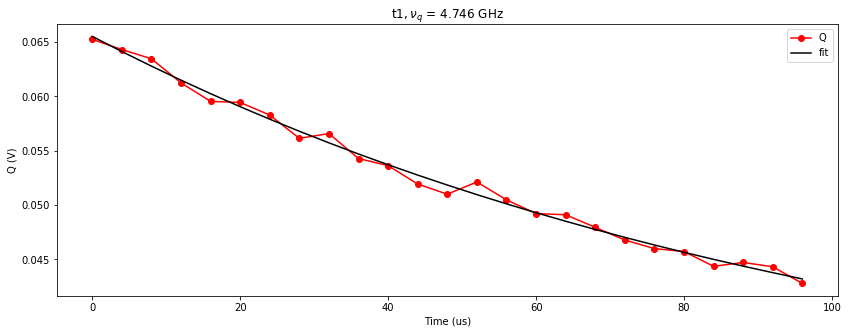

ANALYSIS Q
T1  = 90.86318618807476 us


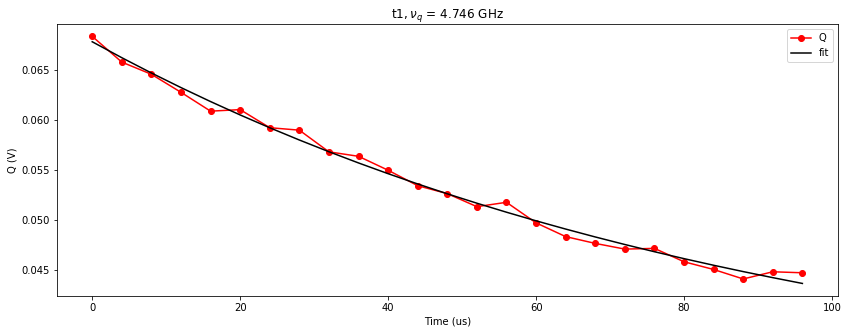

ANALYSIS Q
T1  = 83.39625899529749 us


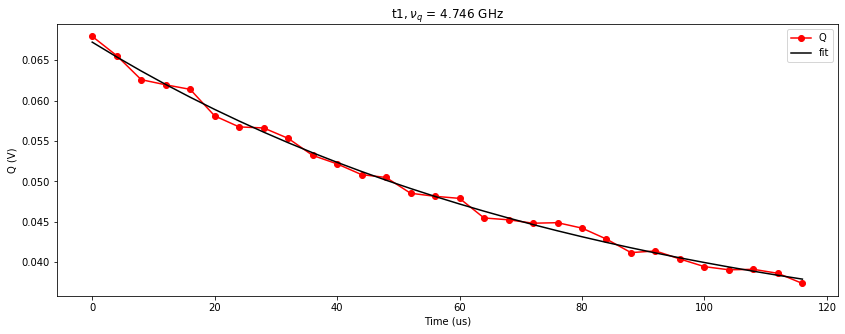

ANALYSIS Q
T1  = 107.42859920249386 us


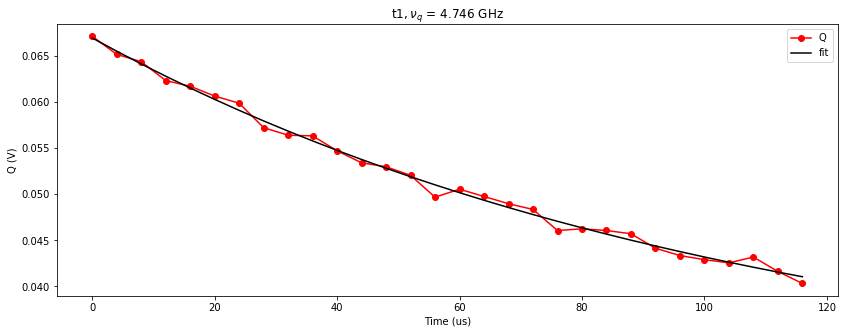

ANALYSIS Q
T1  = 130.9335489354979 us


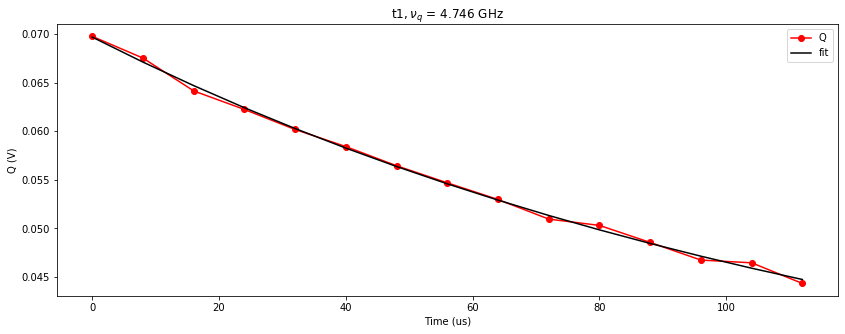

ANALYSIS Q
T1  = 95.88555897429194 us


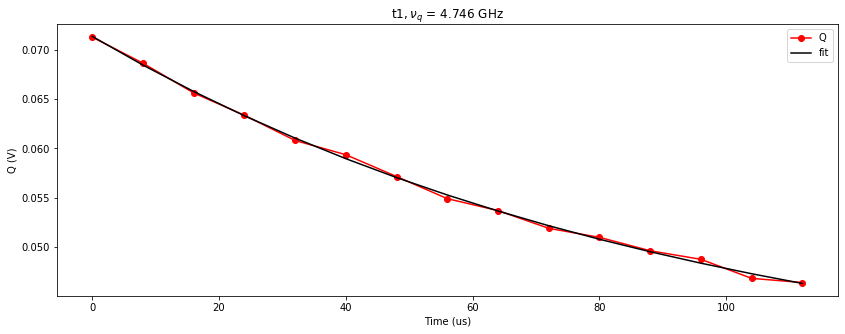

ANALYSIS Q
T1  = 107.62654434213799 us


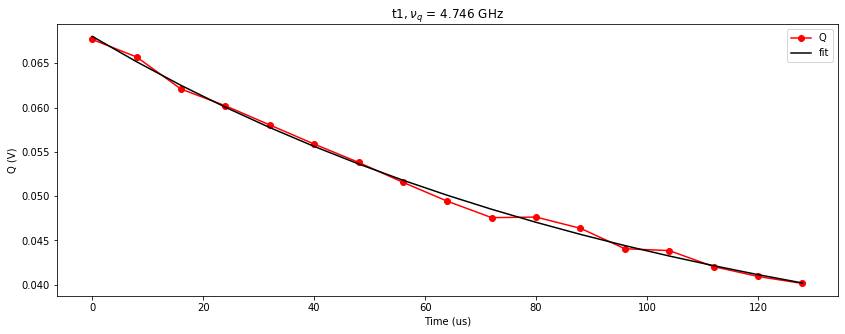

ANALYSIS Q
T1  = 127.50347587809634 us


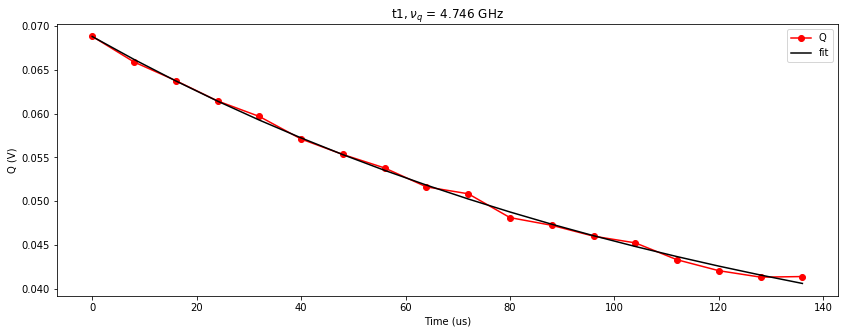

In [84]:
expt_name = 't1'
filelist = [780, 781, 782, 783, 784, 785, 786, 787]
show = 'Q'
fitparams = None
phi=270

for ii,i in enumerate(filelist):
    filenb = i
    t1(filenb, phi=phi, sub_mean=False, show=['Q'], fitparams=fitparams, debug=False)

Fiddled with parameters a bunch, decided to chose one and go for it, can check data over an hour and see what's what

# t1_03 run longer, 500us tail

## time

In [6]:
expt_list =  ['t1']
# 0 = pulse sequence object made
# 1 = pulse sequence generated
# 2 = exp object made
# 3 = exp run
# 4 = exp analysis and save
test5= np.loadtxt( "..\\timetest5")
times = test5
print(times)
for j in np.arange(len(expt_list)):
    #print(times[j,0])
    for i in np.arange(3):
        print(times[i+1] - times[i])
    print("")

[ 0.         31.14006511 37.68102792 91.24797633 99.87957641]
31.140065109
6.540962812000004
53.56694840800001



## trace

ANALYSIS Q
T1  = 119.63205937790866 us


findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


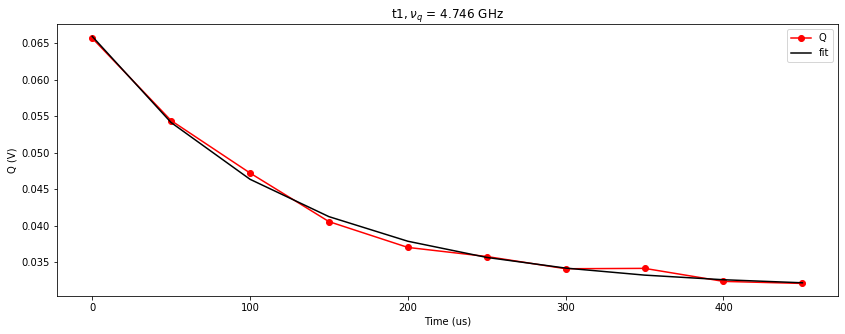

In [6]:
expt_name = 't1'
filelist = [1981]
show = 'Q'
fitparams = None
phi=270

for ii,i in enumerate(filelist):
    filenb = i
    t1(filenb, phi=phi, sub_mean=False, show=['Q'], fitparams=fitparams, debug=False)

## Full T1 trace for cont_t1 run 3

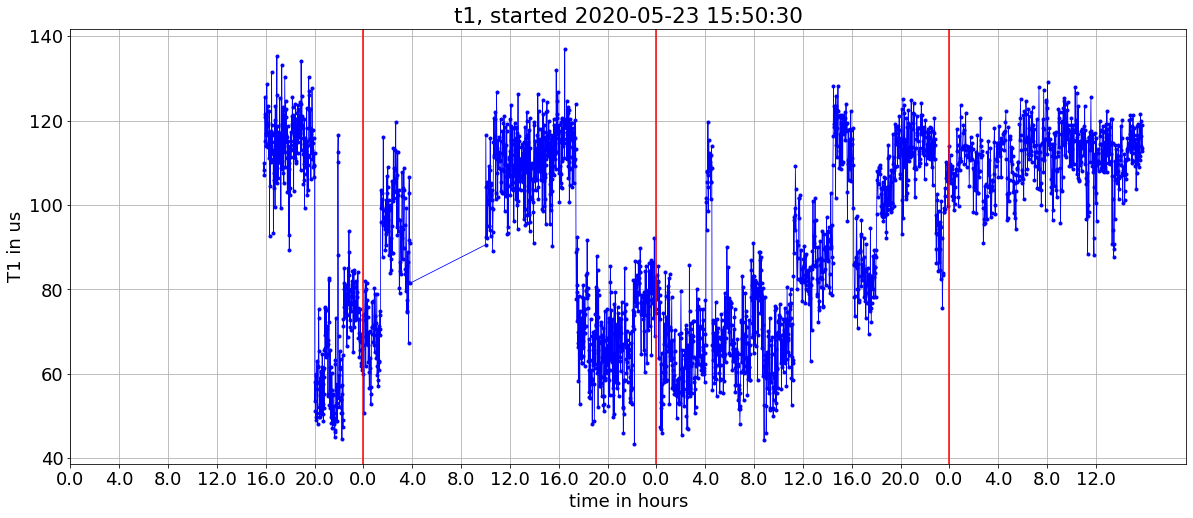

'\nfitlor: returns [offset,amplitude,center,hwhm]\n\nfitdecaysin: Fits decaying sin wave of form: p[0]*np.sin(2.*pi*p[1]*x+p[2]*pi/180.)*np.e**(-1.*(x-x[0])/p[3])+p[4]\n\nexpfunc:  exponential decay (p[0]+p[1]*exp(-(x-p[2])/p[3])\n'

In [24]:
filenb = 3
expt_name = "cont_t1"
#filename = "..\\data\\" + str(filenb).zfill(5) + "_"+expt_name.lower()+".h5"
filename = "..//data//" + str(filenb).zfill(5) + "_"+expt_name.lower()+".h5"

with File(filename,'r') as a:
    #print(a.keys())
    time_iq = array(a["t1_meta"][:,1])
    #print(time_iq - time_iq[0])
    t_start = np.mod(time_iq[0], 24*3600)/3600 - 5 #5 is correction for local time
    t0 = time_iq[0]
    time_iq = (time_iq - time_iq[0])/3600 + t_start
    
    #####PLOTS
    fig = plt.figure(figsize=(20,8))
    fig.add_subplot(111)
    plt.title("t1, started " + time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(t0)))
    plt.xlabel("time in hours")
    plt.ylabel("T1 in us")
    #plt.plot(time_iq, savgol_filter(array(a["t1_fit"])[:, 3], 3, 1))
    
    from scipy.signal import butter,filtfilt
    # Filter requirements.
    fs = 1.0       # sample rate, Hz
    cutoff = 0.02      # desired cutoff frequency of the filter, Hz ,      slightly higher than actual 1.2 Hz
    nyq = 0.5 * fs  # Nyquist Frequency
    order = 2# sin wave can be approx represented as quadratic

    def butter_lowpass_filter(data, cutoff, fs, order, nyq):
        normal_cutoff = cutoff / nyq
        # Get the filter coefficients 
        b, a = butter(order, normal_cutoff, btype='low', analog=False)
        y = filtfilt(b, a, data)
        return y

    data = array(a["t1_fit"])[:, 3]
    #y = butter_lowpass_filter(data, cutoff, fs, order, nyq)

    plt.plot(time_iq, data, 'b-o', markersize=3, linewidth=0.8)
    #plt.plot(time_iq, savgol_filter(data, 21, 1), c='red', linewidth=3)
    #plt.plot(time_iq, y, c='red', linewidth=3)
    day = 24 * (np.arange(int(time_iq[-1]/24))+1)
    for x in day:
        plt.axvline(x, c='r')
    #plt.savefig("t1_cont20.png", dpi=300)
    plt.grid()
    xtick = np.arange(0, time_iq[-1], 4)
    xlab = np.mod(xtick, 24)
    plt.xticks(xtick, xlab)
    plt.show()

'''
fitlor: returns [offset,amplitude,center,hwhm]

fitdecaysin: Fits decaying sin wave of form: p[0]*np.sin(2.*pi*p[1]*x+p[2]*pi/180.)*np.e**(-1.*(x-x[0])/p[3])+p[4]

expfunc:  exponential decay (p[0]+p[1]*exp(-(x-p[2])/p[3])
'''

## look at traces superimposed to understand noise

ANALYSIS Q
T1  = 116.00198645044905 us
ANALYSIS Q
T1  = 106.30169975270927 us
ANALYSIS Q
T1  = 108.44139316921915 us
ANALYSIS Q
T1  = 123.49981021698606 us
ANALYSIS Q
T1  = 116.7452952124885 us
ANALYSIS Q
T1  = 115.00616168858544 us
ANALYSIS Q
T1  = 105.93091080465858 us
ANALYSIS Q
T1  = 105.68632396160376 us
ANALYSIS Q
T1  = 109.35557916453703 us
ANALYSIS Q
T1  = 115.07248372077936 us


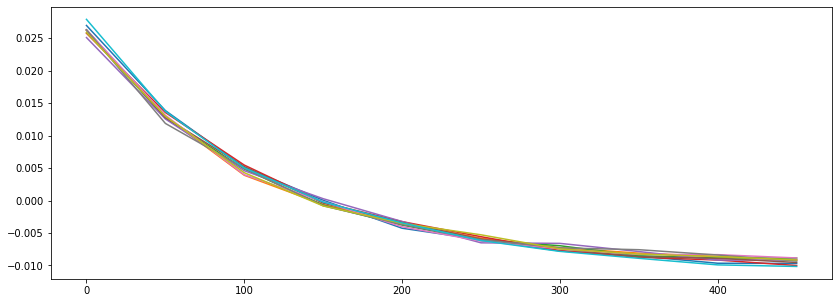

In [16]:
filenb
phi=270
sub_mean=True
show=['Q']
fitparams=None
domain=None
plot=True
debug=False

filelist = np.arange(4625, 4635)
fig = plt.figure(figsize=(14,5))
ax = plt.gca()
for ii,i in enumerate(filelist):
    expt_name = "t1"
    filenb = i
    filename = "..\\data\\" + str(filenb).zfill(5) + "_"+expt_name.lower()+".h5"
    
    with File(filename,'r') as a:
        hardware_cfg =  (json.loads(a.attrs['hardware_cfg']))
        experiment_cfg =  (json.loads(a.attrs['experiment_cfg']))
        quantum_device_cfg =  (json.loads(a.attrs['quantum_device_cfg']))
        expt_params = experiment_cfg[expt_name.lower()]
        readout_params = quantum_device_cfg['readout']
        
        ran = hardware_cfg['awg_info']['keysight_pxi']['m3102_vpp_range'] #range of DAC card for processing
        nu_q = quantum_device_cfg['qubit'][expt_params['on_qubits'][0]]['freq'] #expected qubit freq
        
        I_raw = array(a["I"])
        Q_raw = array(a["Q"])
        (I, Q, mag, phase) = iq_process(f, I_raw, Q_raw, ran, phi, sub_mean)
        t = arange(expt_params['start'],expt_params['stop'],expt_params['step'])[:(len(I))]
        t = t/1000 #convert to us
        
        if debug:
            dig_atten_dr = quantum_device_cfg['qubit_drive_digital_attenuation']
            dig_atten_rd = quantum_device_cfg['readout_drive_digital_attenuation']
            read_lo_pwr = quantum_device_cfg['readout_drive_lo_powers']['1']
            qb_lo_pwr = quantum_device_cfg['qubit_drive_lo_powers']['1']
            print("DEBUG")
            print ("averages =",expt_params['acquisition_num'])
            print("Rd LO pwr= ",read_lo_pwr, "dBm")
            print("Qb LO pwr= ",qb_lo_pwr, "dBm")
            print("Rd atten= ",dig_atten_rd, "dB")
            print("Qb atten= ",dig_atten_dr, "dB")
            print("Readout params",readout_params)
            print("experiment params",expt_params) 
        
        ####Analyze####
        for s in show:
            p = fitexp(t,eval(s),fitparams=fitparams, domain=domain, showfit=False)
        
        if plot:
            #title = expt_name + '$, \\nu_q$ = '+ str(around(nu_q,3)) + ' GHz '
            #fig = plt.figure(figsize=(14,5))
            #ax = fig.add_subplot(111,title=title)

            for s in show:
                if s == "Q":
                    plt.plot(t,eval(s), label = s)
                else:
                    ax.plot(t,eval(s),'bo-',label = s)
                #ax.set_xlabel('Time (us)')
                #ax.set_ylabel(s + " (V)")

                T1 = p[3]
                #plt.plot(t,expfunc(p,t),'k-', label ='fit')
                print("ANALYSIS " + s)
                print("T1  =",p[3],"us")
                if debug:
                    print(p)
        

## histogram

/Users/glcroberts/anaconda/envs/py36/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


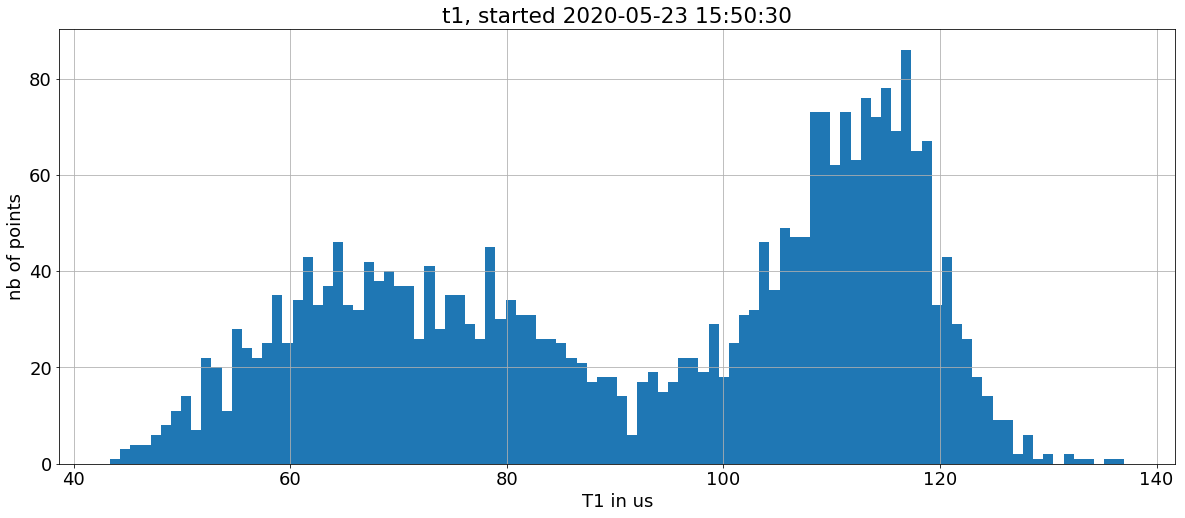

'\nfitlor: returns [offset,amplitude,center,hwhm]\n\nfitdecaysin: Fits decaying sin wave of form: p[0]*np.sin(2.*pi*p[1]*x+p[2]*pi/180.)*np.e**(-1.*(x-x[0])/p[3])+p[4]\n\nexpfunc:  exponential decay (p[0]+p[1]*exp(-(x-p[2])/p[3])\n'

In [13]:
filenb = 3
expt_name = "cont_t1"
#filename = "..\\data\\" + str(filenb).zfill(5) + "_"+expt_name.lower()+".h5"
filename = "..//data//" + str(filenb).zfill(5) + "_"+expt_name.lower()+".h5"

with File(filename,'r') as a:
    #print(a.keys())
    time_iq = array(a["t1_meta"][:,1])
    #print(time_iq - time_iq[0])
    t_start = np.mod(time_iq[0], 24*3600)/3600 - 5 #5 is correction for local time
    t0 = time_iq[0]
    time_iq = (time_iq - time_iq[0])/3600 + t_start
    
    #####PLOTS
    fig = plt.figure(figsize=(20,8))
    fig.add_subplot(111)
    plt.title("t1, started " + time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(t0)))
    #plt.xlabel("time in hours")
    plt.xlabel("T1 in us")
    plt.ylabel("nb of points")
    #plt.plot(time_iq, savgol_filter(array(a["t1_fit"])[:, 3], 3, 1))
    
    from scipy.signal import butter,filtfilt
    # Filter requirements.
    fs = 1.0       # sample rate, Hz
    cutoff = 0.02      # desired cutoff frequency of the filter, Hz ,      slightly higher than actual 1.2 Hz
    nyq = 0.5 * fs  # Nyquist Frequency
    order = 2# sin wave can be approx represented as quadratic

    def butter_lowpass_filter(data, cutoff, fs, order, nyq):
        normal_cutoff = cutoff / nyq
        # Get the filter coefficients 
        b, a = butter(order, normal_cutoff, btype='low', analog=False)
        y = filtfilt(b, a, data)
        return y

    data = array(a["t1_fit"])[:, 3]
    #y = butter_lowpass_filter(data, cutoff, fs, order, nyq)

    plt.hist(data, 100)
    #plt.plot(time_iq, savgol_filter(data, 21, 1), c='red', linewidth=3)
    #plt.plot(time_iq, y, c='red', linewidth=3)
    #day = 24 * (np.arange(int(time_iq[-1]/24))+1)
    #for x in day:
     #   plt.axvline(x, c='r')
    #plt.savefig("t1_cont20.png", dpi=300)
    plt.grid()
    #plt.xlim((0,4))
    #plt.ylim((70,150))
    #plt.xlim(85,80)
    plt.show()

'''
fitlor: returns [offset,amplitude,center,hwhm]

fitdecaysin: Fits decaying sin wave of form: p[0]*np.sin(2.*pi*p[1]*x+p[2]*pi/180.)*np.e**(-1.*(x-x[0])/p[3])+p[4]

expfunc:  exponential decay (p[0]+p[1]*exp(-(x-p[2])/p[3])
'''

## bluefors 3 temperature data

(5743,)
(5743,)
(1436,)
(1436,)


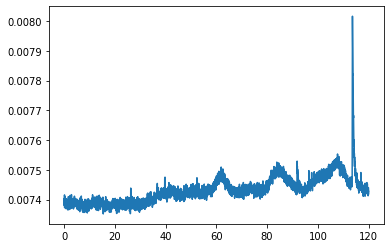

In [37]:
# Temp. sensor: Ch1=PT1, Ch2=PT2, Ch5=Still, Ch6=MC1
# Pres. sensor: 1=Vacuum can, 2=Still, 3=Condense, 4=Scroll, 5=Tank
temp_chn = 6
pres_chn = 5

path = "..\\..\\..\\_BlueFors3\\Logs\\"
#my guess is month-day-year
(xdata, ydata) =  read_tlog_multdays(20, [5], [23, 24, 25, 26], temp_chn, path=path, mult_run = True, offset_hours = 0)
(xdata1, ydata1) =  read_tlog_multdays(20, [5], [27], temp_chn, path=path, mult_run = True, offset_hours = 0)
print(ydata.shape)
print(xdata.shape)
print(ydata1.shape)
print(xdata1.shape)

for i in range(len(xdata)):
    xdata[i]= xdata[i].total_seconds()/3600
    
for i in range(len(xdata1)):
    xdata1[i]= xdata1[i].total_seconds()/3600 + xdata[-1]
    
xdata = np.concatenate([xdata, xdata1])
ydata = np.concatenate([ydata, ydata1])

plt.plot(xdata, ydata)


### Temperature and T1 superimposed

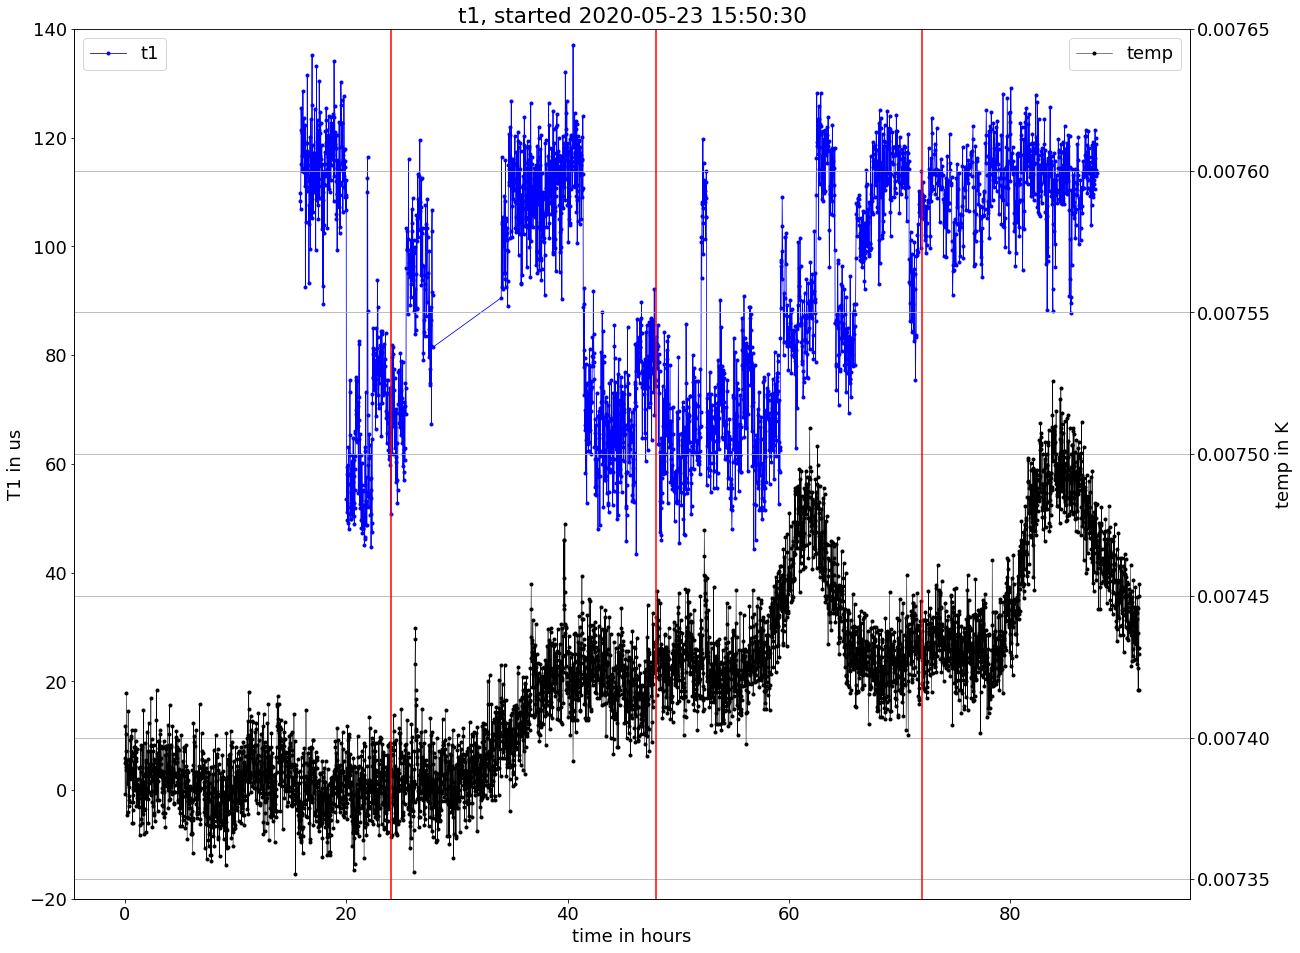

'\nfitlor: returns [offset,amplitude,center,hwhm]\n\nfitdecaysin: Fits decaying sin wave of form: p[0]*np.sin(2.*pi*p[1]*x+p[2]*pi/180.)*np.e**(-1.*(x-x[0])/p[3])+p[4]\n\nexpfunc:  exponential decay (p[0]+p[1]*exp(-(x-p[2])/p[3])\n'

In [63]:
filenb = 3
expt_name = "cont_t1"
#filename = "..\\data\\" + str(filenb).zfill(5) + "_"+expt_name.lower()+".h5"
filename = "..//data//" + str(filenb).zfill(5) + "_"+expt_name.lower()+".h5"

with File(filename,'r') as a:
    #print(a.keys())
    time_iq = array(a["t1_meta"][:,1])
    #print(time_iq - time_iq[0])
    t_start = np.mod(time_iq[0], 24*3600)/3600 - 5 #5 is correction for local time
    t0 = time_iq[0]
    time_iq = (time_iq - time_iq[0])/3600 + t_start
    
    #####PLOTS
    fig = plt.figure(figsize=(20,16))
    fig.add_subplot(111)
    plt.title("t1, started " + time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(t0)))
    plt.xlabel("time in hours")
    plt.ylabel("T1 in us")
    #plt.plot(time_iq, savgol_filter(array(a["t1_fit"])[:, 3], 3, 1))
    
    from scipy.signal import butter,filtfilt
    # Filter requirements.
    fs = 1.0       # sample rate, Hz
    cutoff = 0.02      # desired cutoff frequency of the filter, Hz ,      slightly higher than actual 1.2 Hz
    nyq = 0.5 * fs  # Nyquist Frequency
    order = 2# sin wave can be approx represented as quadratic

    def butter_lowpass_filter(data, cutoff, fs, order, nyq):
        normal_cutoff = cutoff / nyq
        # Get the filter coefficients 
        b, a = butter(order, normal_cutoff, btype='low', analog=False)
        y = filtfilt(b, a, data)
        return y

    data = array(a["t1_fit"])[:, 3]
    #y = butter_lowpass_filter(data, cutoff, fs, order, nyq)

    plt.plot(time_iq, data, 'b-o', markersize=3, linewidth=0.8, label="t1")
    
    temp_chn = 6
    pres_chn = 5

    path = "..\\..\\..\\_BlueFors3\\Logs\\"
    (xdata, ydata) =  read_tlog_multdays(20, [5], [23, 24, 25, 26], temp_chn, path=path, mult_run = True, offset_hours = 0)
    for i in range(len(xdata)):
        xdata[i]= xdata[i].total_seconds()
    ax = plt.gca()
    ax2 = ax.twinx()
    ax2.plot(xdata/3600, ydata, 'k-o', markersize=3, linewidth=0.5, label="temp")
    
    day = 24 * (np.arange(int(time_iq[-1]/24))+1)
    for x in day:
        plt.axvline(x, c='r')
    plt.grid()
    ax.set_ylim((-20,140))
    ax2.set_ylim(top = 0.00765)
    ax2.set_ylabel("temp in K")
    ax.legend(loc="upper left")
    ax2.legend()
    plt.show()

'''
fitlor: returns [offset,amplitude,center,hwhm]

fitdecaysin: Fits decaying sin wave of form: p[0]*np.sin(2.*pi*p[1]*x+p[2]*pi/180.)*np.e**(-1.*(x-x[0])/p[3])+p[4]

expfunc:  exponential decay (p[0]+p[1]*exp(-(x-p[2])/p[3])
'''

# t1_04 run, 750us tail

## time

In [18]:
expt_list =  ['t1']
# 0 = pulse sequence object made
# 1 = pulse sequence generated
# 2 = exp object made
# 3 = exp run
# 4 = exp analysis and save
test5= np.loadtxt( "..\\timetest5")
times = test5
print(times)
for j in np.arange(len(expt_list)):
    #print(times[j,0])
    for i in np.arange(3):
        print(times[i+1] - times[i])
    print("")

[  0.          34.35626685  40.90213631 108.49893718 109.12013431]
34.356266853
6.5458694579999985
67.59680086700001



## trace

ANALYSIS Q
T1  = 101.82522430017075 us


C:\Lib\python\slab\dsfit.py:132: RuntimeWarning: overflow encountered in power
  return p[0]+p[1]*math.e**(-(x-p[2])/p[3])


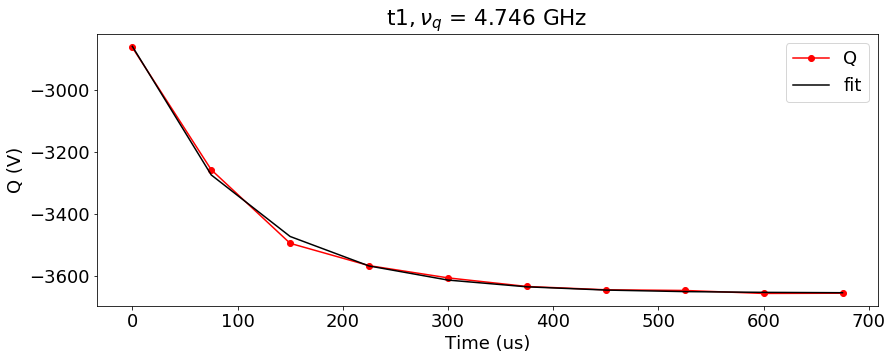

In [130]:
expt_name = 't1'
filelist = [4845]
show = 'Q'
fitparams = None
phi=270

for ii,i in enumerate(filelist):
    filenb = i
    t1(filenb, phi=phi, sub_mean=False, show=['Q'], fitparams=fitparams, debug=False)

ANALYSIS Q
T1  = 120.55519883770474 us
ANALYSIS Q
T1  = 120.16250645436122 us
ANALYSIS Q
T1  = 117.89086734693299 us
ANALYSIS Q
T1  = 121.63482687933309 us
ANALYSIS Q
T1  = 119.16212137932891 us
ANALYSIS Q
T1  = 112.98245377765274 us
ANALYSIS Q
T1  = 119.70144851618004 us
ANALYSIS Q
T1  = 115.700844701467 us
ANALYSIS Q
T1  = 124.00026594495705 us
ANALYSIS Q
T1  = 116.50375960642496 us


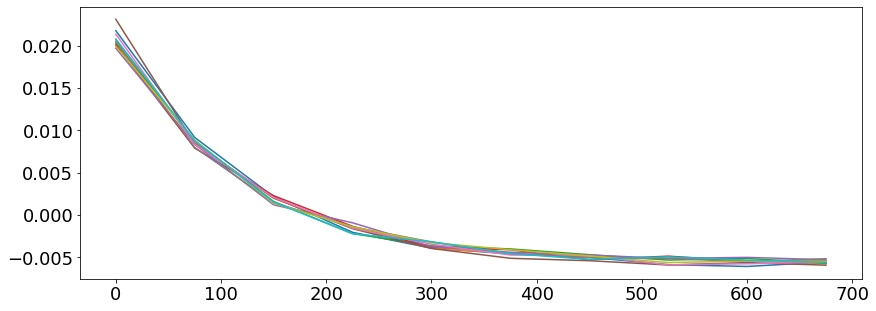

In [133]:
filenb
phi=270
sub_mean=True
show=['Q']
fitparams=None
domain=None
plot=True
debug=False

filelist = np.arange(4855, 4865)
fig = plt.figure(figsize=(14,5))
ax = plt.gca()
for ii,i in enumerate(filelist):
    expt_name = "t1"
    filenb = i
    filename = "..\\data\\" + str(filenb).zfill(5) + "_"+expt_name.lower()+".h5"
    
    with File(filename,'r') as a:
        hardware_cfg =  (json.loads(a.attrs['hardware_cfg']))
        experiment_cfg =  (json.loads(a.attrs['experiment_cfg']))
        quantum_device_cfg =  (json.loads(a.attrs['quantum_device_cfg']))
        expt_params = experiment_cfg[expt_name.lower()]
        readout_params = quantum_device_cfg['readout']
        
        ran = hardware_cfg['awg_info']['keysight_pxi']['m3102_vpp_range'] #range of DAC card for processing
        nu_q = quantum_device_cfg['qubit'][expt_params['on_qubits'][0]]['freq'] #expected qubit freq
        
        I_raw = array(a["I"])
        Q_raw = array(a["Q"])
        (I, Q, mag, phase) = iq_process(f, I_raw, Q_raw, ran, phi, sub_mean)
        t = arange(expt_params['start'],expt_params['stop'],expt_params['step'])[:(len(I))]
        t = t/1000 #convert to us
        
        if debug:
            dig_atten_dr = quantum_device_cfg['qubit_drive_digital_attenuation']
            dig_atten_rd = quantum_device_cfg['readout_drive_digital_attenuation']
            read_lo_pwr = quantum_device_cfg['readout_drive_lo_powers']['1']
            qb_lo_pwr = quantum_device_cfg['qubit_drive_lo_powers']['1']
            print("DEBUG")
            print ("averages =",expt_params['acquisition_num'])
            print("Rd LO pwr= ",read_lo_pwr, "dBm")
            print("Qb LO pwr= ",qb_lo_pwr, "dBm")
            print("Rd atten= ",dig_atten_rd, "dB")
            print("Qb atten= ",dig_atten_dr, "dB")
            print("Readout params",readout_params)
            print("experiment params",expt_params) 
        
        ####Analyze####
        for s in show:
            p = fitexp(t,eval(s),fitparams=fitparams, domain=domain, showfit=False)
        
        if plot:
            #title = expt_name + '$, \\nu_q$ = '+ str(around(nu_q,3)) + ' GHz '
            #fig = plt.figure(figsize=(14,5))
            #ax = fig.add_subplot(111,title=title)

            for s in show:
                if s == "Q":
                    plt.plot(t,eval(s), label = s)
                else:
                    ax.plot(t,eval(s),'bo-',label = s)
                #ax.set_xlabel('Time (us)')
                #ax.set_ylabel(s + " (V)")

                T1 = p[3]
                #plt.plot(t,expfunc(p,t),'k-', label ='fit')
                print("ANALYSIS " + s)
                print("T1  =",p[3],"us")
                if debug:
                    print(p)
        

## Full T1 trace for cont_t1 run 4

In [8]:
start_Kevin_time = time.time()
print(start_Kevin_time)
start_Kevin_time = 1590858085.6559944

1592335393.9062903


60.023793331782024


findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


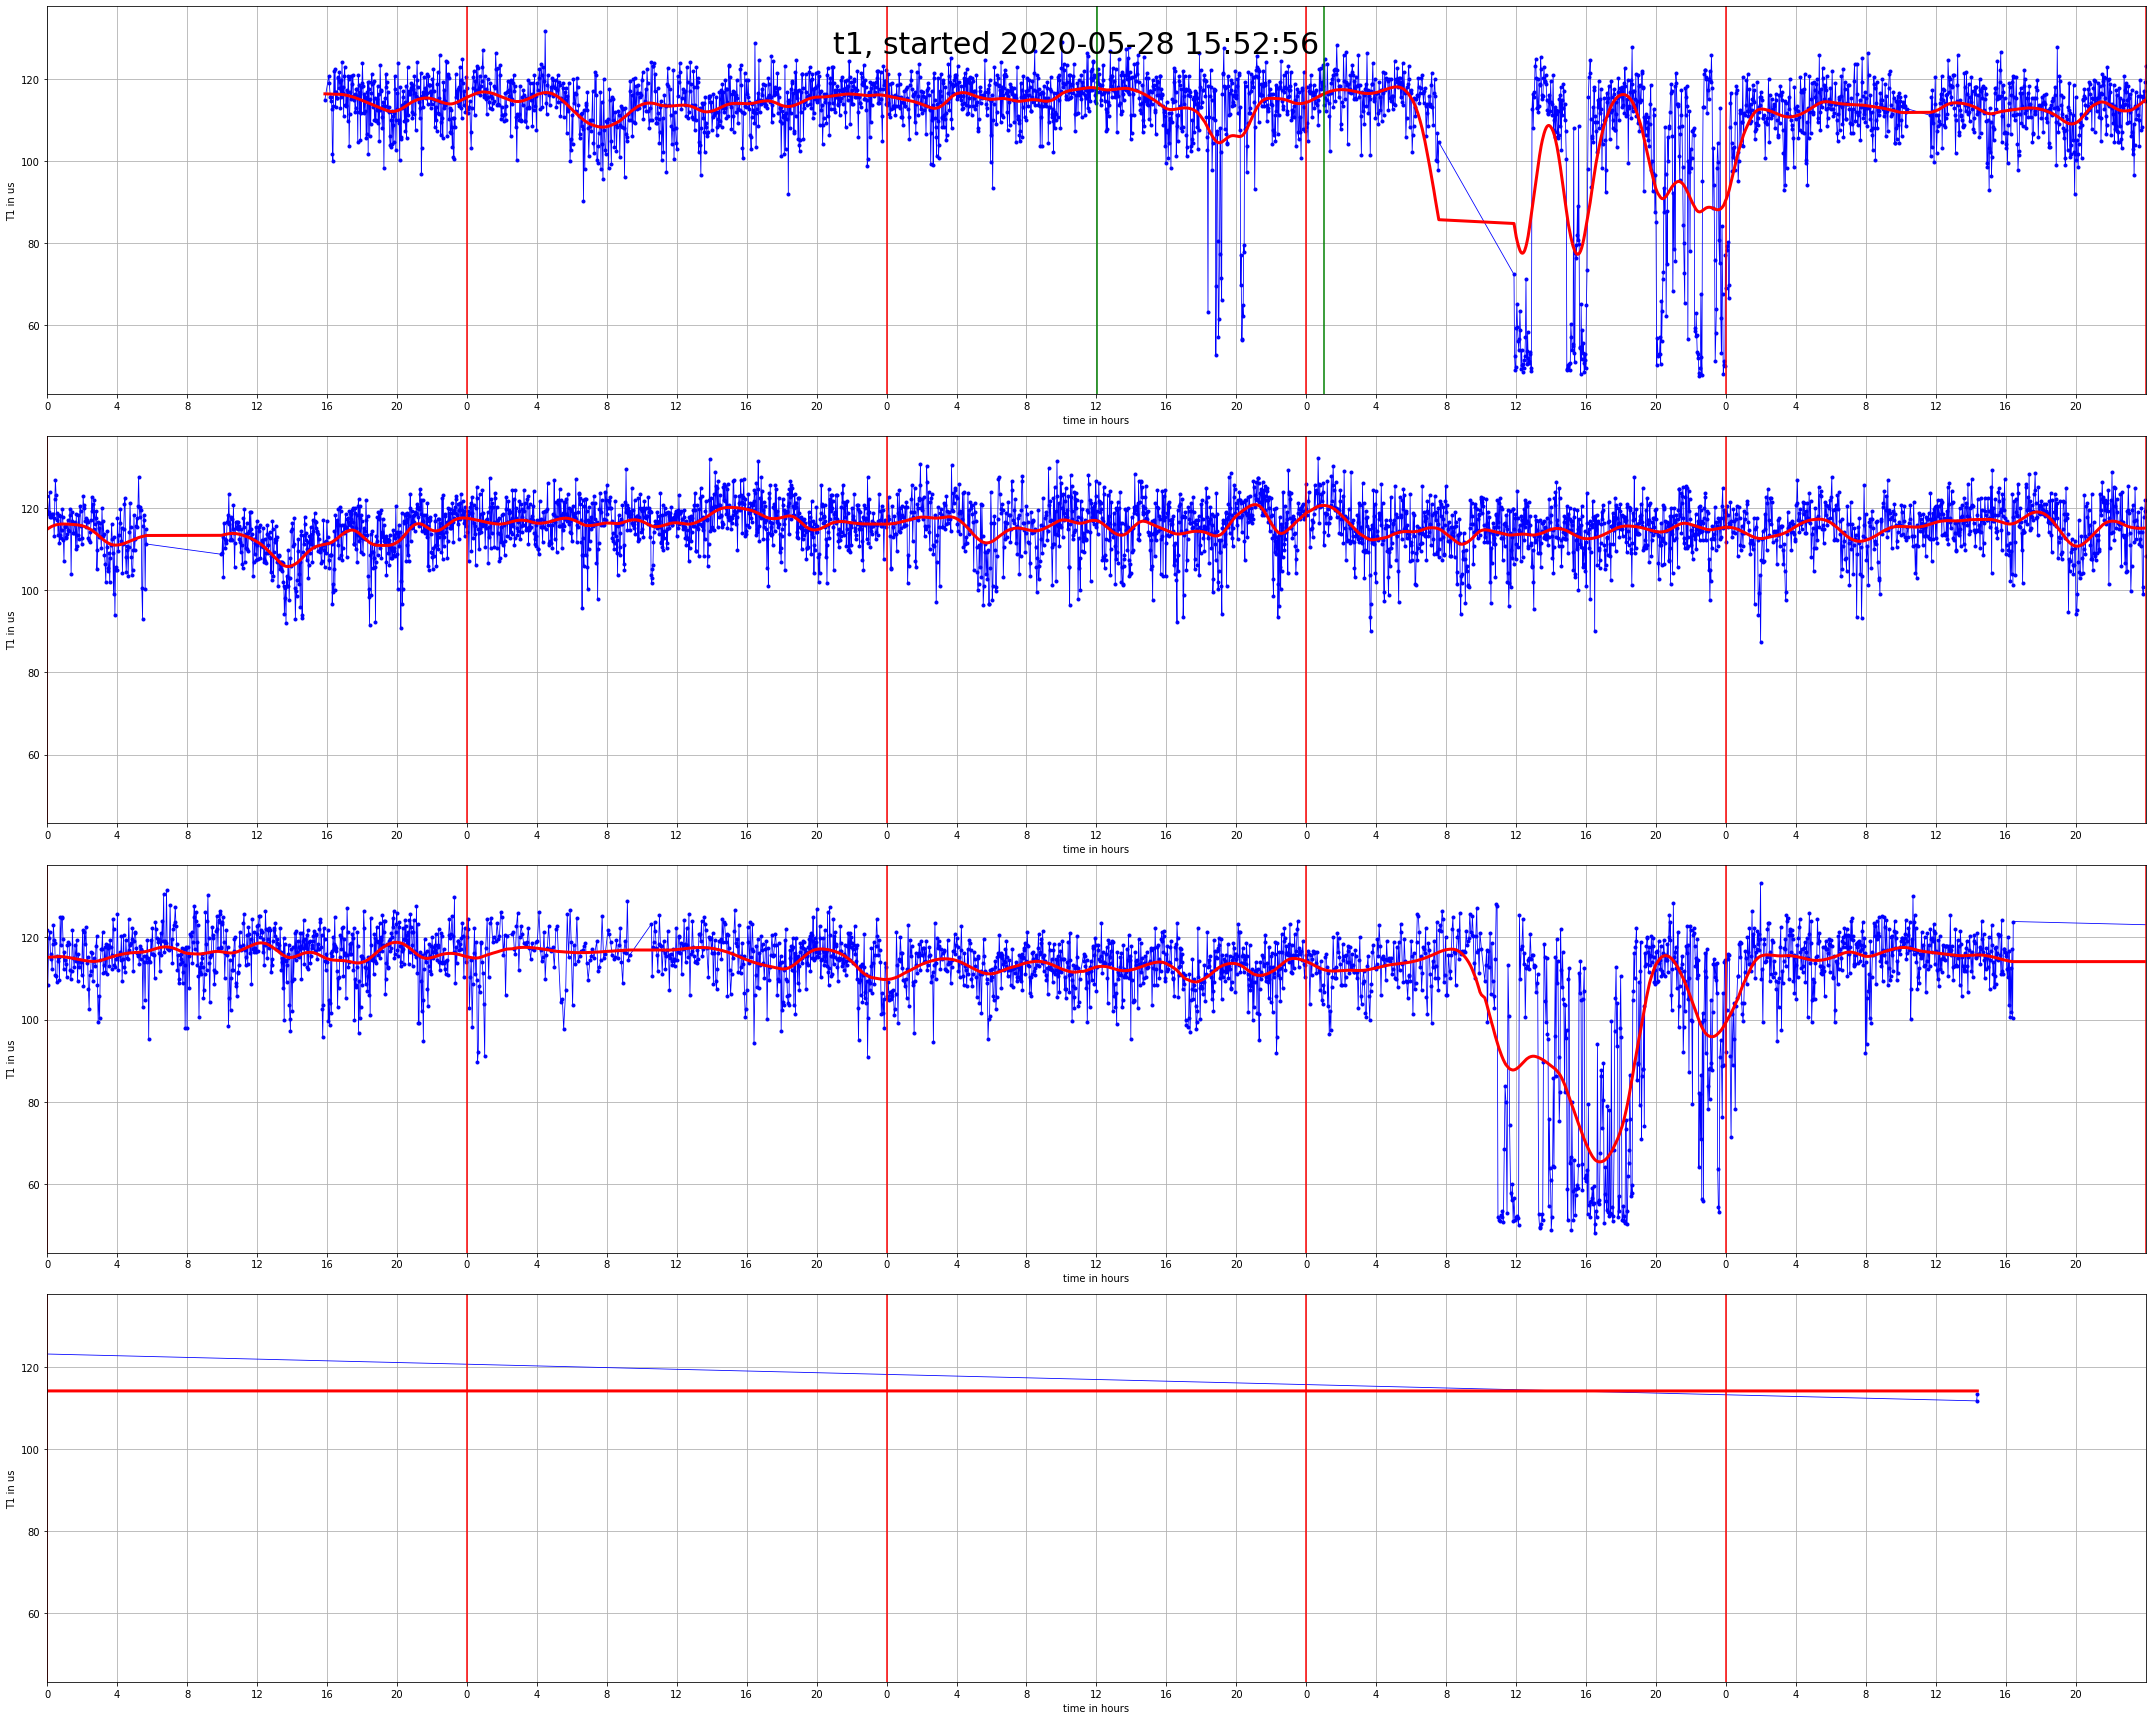

'\nfitlor: returns [offset,amplitude,center,hwhm]\n\nfitdecaysin: Fits decaying sin wave of form: p[0]*np.sin(2.*pi*p[1]*x+p[2]*pi/180.)*np.e**(-1.*(x-x[0])/p[3])+p[4]\n\nexpfunc:  exponential decay (p[0]+p[1]*exp(-(x-p[2])/p[3])\n'

In [9]:
start_Kevin_time = 1590858085.6559944
filenb = 4
expt_name = "cont_t1"
#filename = "..\\data\\" + str(filenb).zfill(5) + "_"+expt_name.lower()+".h5"
filename = "..//data//" + str(filenb).zfill(5) + "_"+expt_name.lower()+".h5"

with File(filename,'r') as a:
    time_iq = array(a["t1_meta"][:,1])
    t_start = np.mod(time_iq[0], 24*3600)/3600 - 5 #5 is correction for local time, tstart is time in hours of measurement start
    t0 = time_iq[0]
    time_iq = (time_iq - time_iq[0])/3600 + t_start #set start ttime = time in hours on day of measurement start
    
    ###Kevin time
    Kt = (start_Kevin_time - t0)/3600 + t_start
    print(Kt)
    
    # Filter requirements.
    fs = 1.0       # sample rate, Hz
    cutoff = 0.01      # desired cutoff frequency of the filter, Hz ,      slightly higher than actual 1.2 Hz
    nyq = 0.5 * fs  # Nyquist Frequency
    order = 2# sin wave can be approx represented as quadratic
    data = array(a["t1_fit"])[:, 3]
    y = butter_lowpass_filter(data, cutoff, fs, order, nyq)
    
    #####PLOTS
    fig = plt.figure(figsize=(30,24))
    fig.suptitle("t1, started " + time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(t0)), fontsize=30)
    
    

    num_row=4
    num_days=5
    for i in range(num_row):
        fig.add_subplot(num_row,1,i+1)
        
        plt.xlabel("time in hours")
        plt.ylabel("T1 in us")

        plt.plot(time_iq, data, 'b-o', markersize=3, linewidth=0.8)
        #plt.plot(time_iq, savgol_filter(data, 9, 1), c='red', linewidth=3)
        plt.plot(time_iq, y, c='red', linewidth=3)
        
        day = 24 * (np.arange(int(time_iq[-1]/24))+1)
        for x in day:
            plt.axvline(x, c='r')
        plt.axvline(Kt, c='g')
        plt.axvline(Kt + 13, c='g')
        plt.grid()
        
        plt.xlim(i*24*num_days, (i+1)*24*num_days)
        xtick = np.arange(i*24*num_days, (i+1)*24*num_days, 4)
        xlab = np.mod(xtick, 24)
        plt.xticks(xtick, xlab)
        plt.tight_layout()
        
        
    
    
    plt.show()

'''
fitlor: returns [offset,amplitude,center,hwhm]

fitdecaysin: Fits decaying sin wave of form: p[0]*np.sin(2.*pi*p[1]*x+p[2]*pi/180.)*np.e**(-1.*(x-x[0])/p[3])+p[4]

expfunc:  exponential decay (p[0]+p[1]*exp(-(x-p[2])/p[3])
'''

## Full trace for cont_t1 run 4 with temperature data

60.023793331782024


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


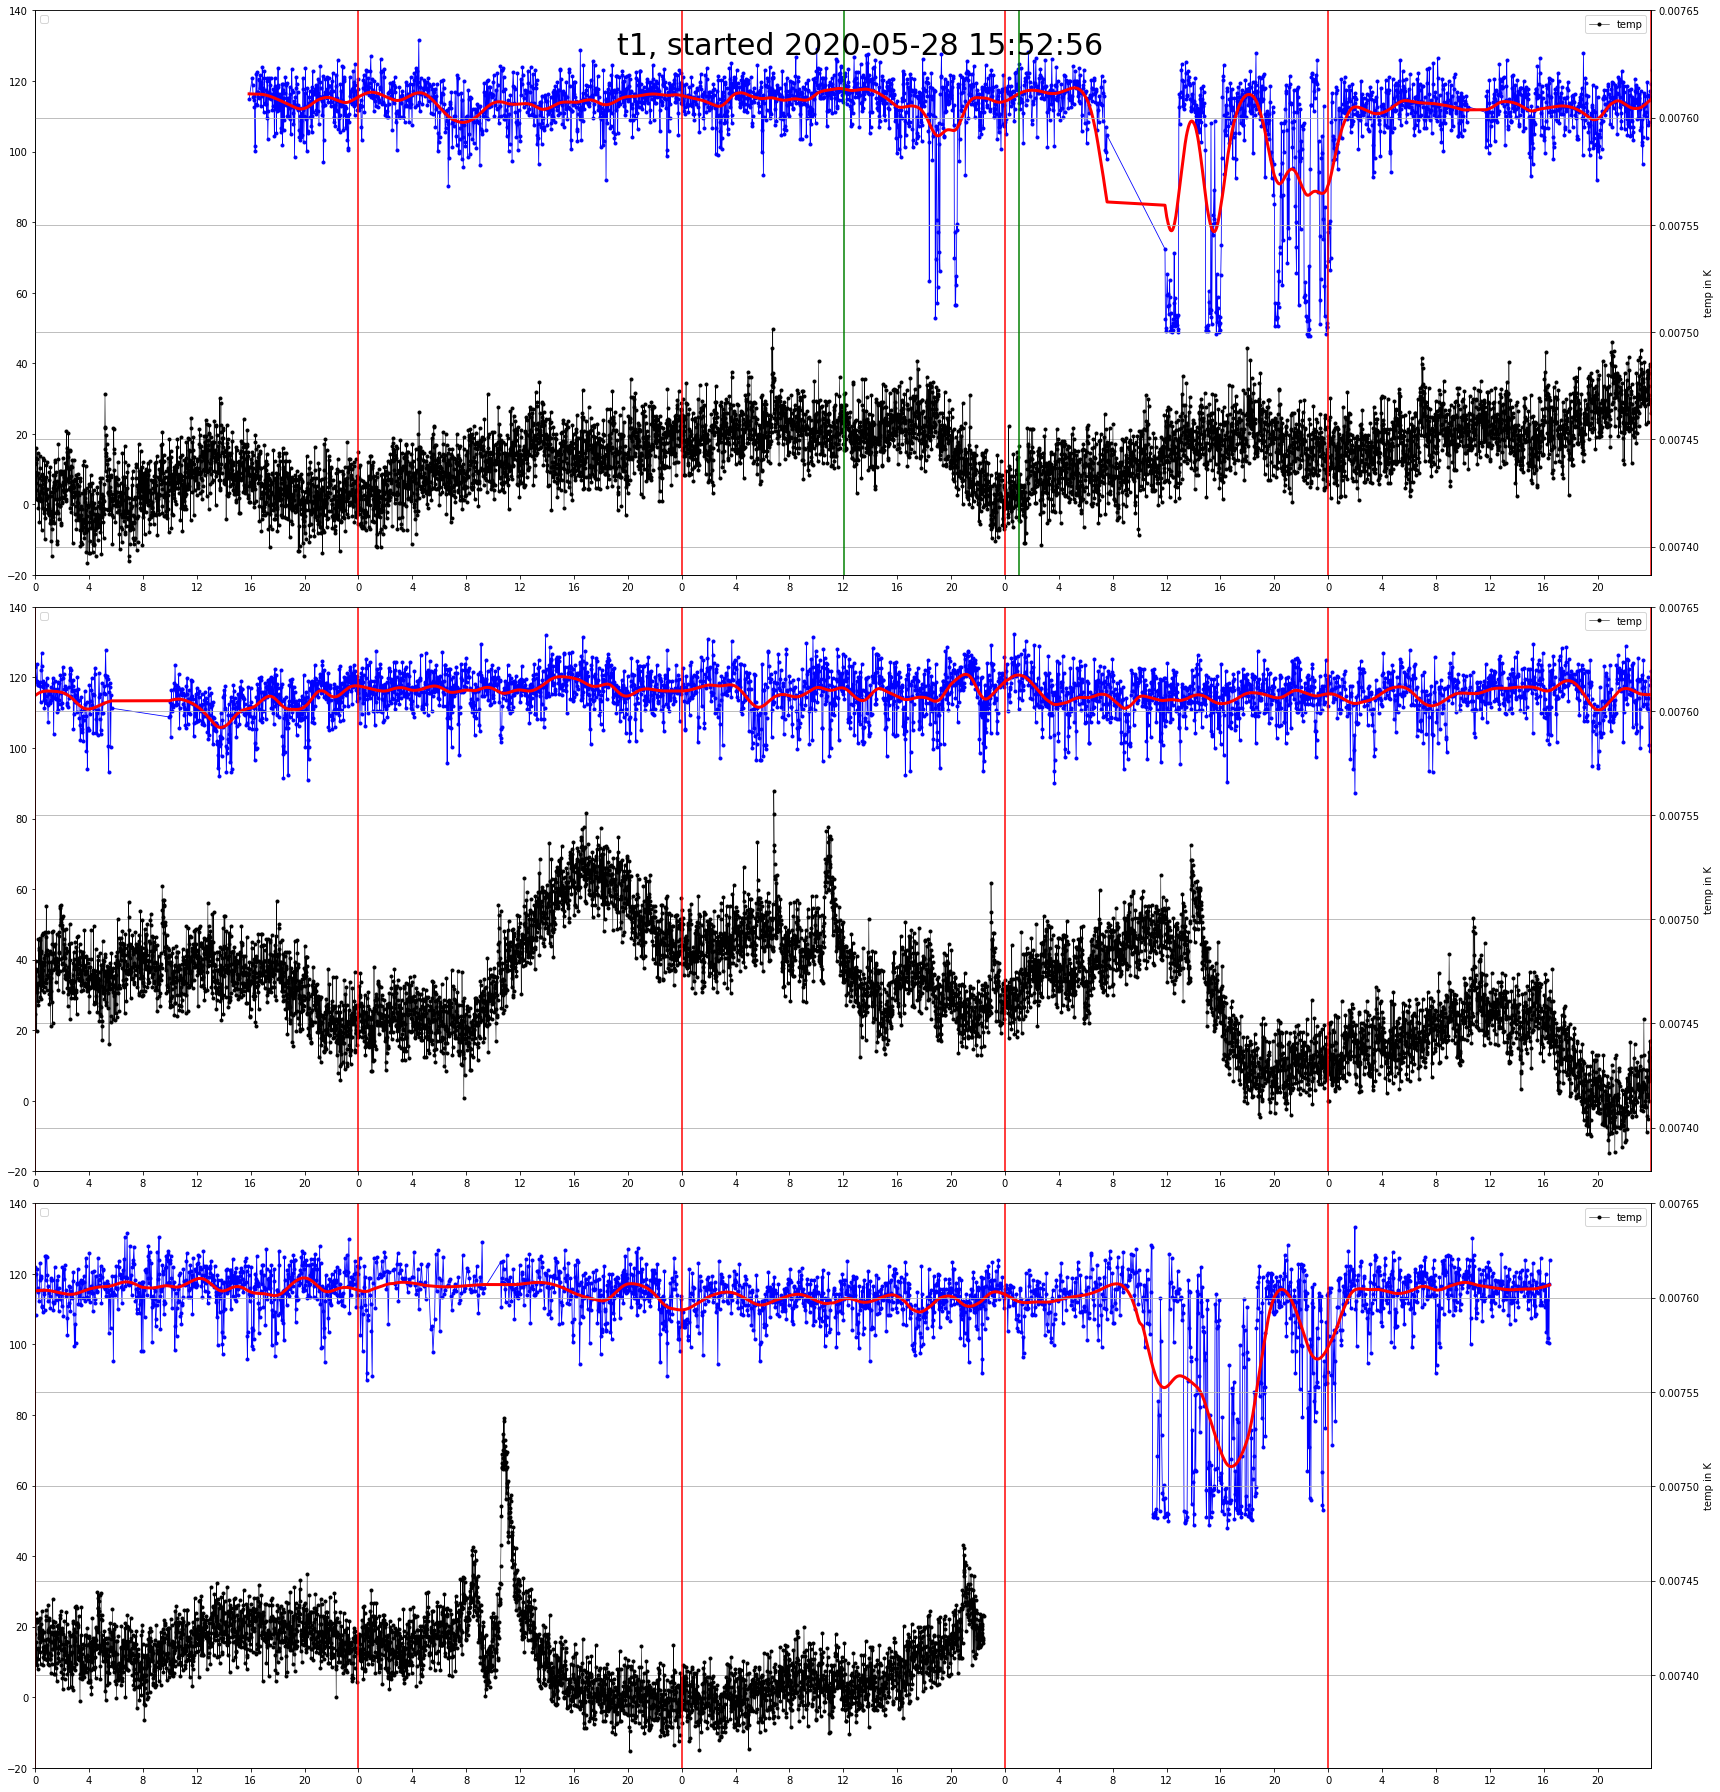

'\nfitlor: returns [offset,amplitude,center,hwhm]\n\nfitdecaysin: Fits decaying sin wave of form: p[0]*np.sin(2.*pi*p[1]*x+p[2]*pi/180.)*np.e**(-1.*(x-x[0])/p[3])+p[4]\n\nexpfunc:  exponential decay (p[0]+p[1]*exp(-(x-p[2])/p[3])\n'

In [61]:
start_Kevin_time = 1590858085.6559944
filenb = 4
expt_name = "cont_t1"
#filename = "..\\data\\" + str(filenb).zfill(5) + "_"+expt_name.lower()+".h5"
filename = "..//data//" + str(filenb).zfill(5) + "_"+expt_name.lower()+".h5"

with File(filename,'r') as a:
    time_iq = array(a["t1_meta"][:,1])
    t_start = np.mod(time_iq[0], 24*3600)/3600 - 5 #5 is correction for local time, tstart is time in hours of measurement start
    t0 = time_iq[0]
    time_iq = (time_iq - time_iq[0])/3600 + t_start #set start ttime = time in hours on day of measurement start
    
    ###Kevin time
    Kt = (start_Kevin_time - t0)/3600 + t_start
    print(Kt)
    
    # Filter requirements.
    fs = 1.0       # sample rate, Hz
    cutoff = 0.01      # desired cutoff frequency of the filter, Hz ,      slightly higher than actual 1.2 Hz
    nyq = 0.5 * fs  # Nyquist Frequency
    order = 2# sin wave can be approx represented as quadratic
    data = array(a["t1_fit"])[:, 3]
    y = butter_lowpass_filter(data, cutoff, fs, order, nyq)
    
    #####PLOTS
    num_row=3
    num_days=5
    fig = plt.figure(figsize=(num_row*8,num_days*5))
    fig.suptitle("t1, started " + time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(t0)), fontsize=30)

    
    
    temp_chn = 6
    pres_chn = 5
    fridge_path = "..\\..\\..\\_BlueFors3\\Logs\\"
    
    for i in range(num_row):
        ax = fig.add_subplot(num_row,1,i+1)
        
        ##T1 data and filtering/smoothing 
        plt.plot(time_iq, data, 'b-o', markersize=3, linewidth=0.8)
        #plt.plot(time_iq, savgol_filter(data, 9, 1), c='red', linewidth=3)
        plt.plot(time_iq, y, c='red', linewidth=3)
        
        ##bluefors temperature data
        if i==0:
            (xdata, ydata) =  read_tlog_multdays(20, [5], [28, 29, 30, 31], temp_chn, path=fridge_path, mult_run = True, offset_hours = 0)
            for j in range(len(xdata)):
                xdata[j]= xdata[j].total_seconds()
            (xdata1, ydata1) =  read_tlog_multdays(20, [6], [1], temp_chn, path=fridge_path, mult_run = True, offset_hours = 0)
            for j in range(len(xdata1)):
                xdata1[j]= xdata1[j].total_seconds() + xdata[-1]
            xdata = np.concatenate([xdata, xdata1])
            ydata = np.concatenate([ydata, ydata1])
    
        elif i==num_row-1:
            (xdata, ydata) =  read_tlog_multdays(20, [6], [2+(i-1)*num_days, 3+(i-1)*num_days, 4+(i-1)*num_days], temp_chn, path=fridge_path, mult_run = True, offset_hours = 0)
            for k in range(len(xdata)):
                xdata[k]= xdata[k].total_seconds()
        
        else:
            (xdata, ydata) =  read_tlog_multdays(20, [6], [2+(i-1)*num_days, 3+(i-1)*num_days, 4+(i-1)*num_days, 5+(i-1)*num_days, 6+(i-1)*num_days], temp_chn, path=fridge_path, mult_run = True, offset_hours = 0)
            for k in range(len(xdata)):
                xdata[k]= xdata[k].total_seconds()
            
        ax2 = ax.twinx()
        ax2.plot(xdata/3600 + i*24*num_days, ydata, 'k-o', markersize=3, linewidth=0.5, label="temp")
    
        ##grid stuff
        day = 24 * (np.arange(int(time_iq[-1]/24))+1)
        for x in day:
            plt.axvline(x, c='r')
        plt.axvline(Kt, c='g')
        plt.axvline(Kt + 13, c='g')
        plt.grid()
        
        #axis stuff
        plt.xlabel("time in hours")
        plt.ylabel("T1 in us")
        
        plt.xlim(i*24*num_days, (i+1)*24*num_days)
        xtick = np.arange(i*24*num_days, (i+1)*24*num_days, 4)
        xlab = np.mod(xtick, 24)
        plt.xticks(xtick, xlab)
        
        ax.set_ylim((-20,140))
        ax2.set_ylim(top = 0.00765)
        ax2.set_ylabel("temp in K")
        
        ax.legend(loc="upper left")
        ax2.legend()
        plt.tight_layout()
           
    plt.show()

'''
fitlor: returns [offset,amplitude,center,hwhm]

fitdecaysin: Fits decaying sin wave of form: p[0]*np.sin(2.*pi*p[1]*x+p[2]*pi/180.)*np.e**(-1.*(x-x[0])/p[3])+p[4]

expfunc:  exponential decay (p[0]+p[1]*exp(-(x-p[2])/p[3])
'''